In [113]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import joblib

from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm import Session
import os

In [114]:
from dotenv import load_dotenv
import os

load_dotenv()  # charge .env dans os.environ

DATABASE_URL = os.getenv("DATABASE_URL")
DATABASE_URL
from sqlalchemy import create_engine

engine = create_engine(DATABASE_URL)
pd.read_sql("SELECT 1", engine)

,?column?
0,1


# Données

In [115]:
sessions = pd.read_sql("SELECT * FROM run_sessions ORDER BY start_time", engine)
sessions.tail(2)

,id,user_id,start_time,distance_km,duration_min,avg_hr,z1_min,z2_min,z3_min,z4_min,z5_min,elevation_m,active_kcal
297,88544efa-cad1-4241-8382-4781ecdeef88,f90a87bf-2104-4456-8a54-b42c307337e7,2026-01-28 09:17:15,9.224267,55.627406,166.303962,7.840152,20.470633,5.95019,7.840206,14.250442,6.4,418.744299
298,2d0bf8aa-4015-4044-b62c-6fe9b8b26a57,f90a87bf-2104-4456-8a54-b42c307337e7,2026-01-31 07:18:57,15.012428,85.801712,164.279915,3.129909,20.450378,59.84093,2.360042,0.000000,40.9,668.120000


In [116]:
week = pd.read_sql("SELECT * FROM run_weeks ORDER BY start_date DESC", engine)
week.head(2)

,user_id,year,iso_week,start_date,end_date,sessions_count,total_distance_km,total_duration_min,z1_z3_pct,z4_z5_pct,avg_load,created_at
0,f90a87bf-2104-4456-8a54-b42c307337e7,2026,5,2026-01-26,2026-01-31,3,29.248084,180.274195,0.864951,0.135049,229.175576,2026-02-02 14:14:01.402095
1,f90a87bf-2104-4456-8a54-b42c307337e7,2026,4,2026-01-20,2026-01-24,3,31.669952,202.032657,0.846277,0.153723,265.770008,2026-02-02 14:14:01.402095


In [117]:
# s'assurer que ce sont des datetime
week["start_date"] = pd.to_datetime(week["start_date"])
week["end_date"] = pd.to_datetime(week["end_date"])

# calcul des clés ISO
week["iso_year"] = week["start_date"].dt.isocalendar().year
week["iso_week"] = week["start_date"].dt.isocalendar().week

# correction propre
week.loc[
    (week["iso_year"] == 2025) & (week["iso_week"] == 37),
    "sessions_count",
] = 4


In [118]:
sessions["start_time"] = pd.to_datetime(
    sessions["start_time"], utc=True, errors="coerce"
)

# clé jour (UTC). Si tu veux en heure locale FR, voir Option B.
sessions["start_time"] = sessions["start_time"].dt.floor("D")

sessions = sessions.groupby("start_time", as_index=False).agg(
    distance_km=("distance_km", "sum"),
    duration_min=("duration_min", "sum"),
    z1_min=("z1_min", "sum"),
    z2_min=("z2_min", "sum"),
    z3_min=("z3_min", "sum"),
    z4_min=("z4_min", "sum"),
    z5_min=("z5_min", "sum"),
)

# garde-fous
sessions["pace_min_per_km"] = sessions["duration_min"] / sessions["distance_km"].replace(
    0, np.nan
)
sessions["low_intensity_pct"] = (
    sessions["z1_min"] + sessions["z2_min"] + sessions["z3_min"]
) / sessions["duration_min"].replace(0, np.nan)
sessions["high_intensity_pct"] = (sessions["z4_min"] + sessions["z5_min"]) / sessions[
    "duration_min"
].replace(0, np.nan)

sessions.tail()


,start_time,distance_km,duration_min,z1_min,z2_min,z3_min,z4_min,z5_min,pace_min_per_km,low_intensity_pct,high_intensity_pct
269,2026-01-22 00:00:00+00:00,5.103864,42.604334,46.160460,0.000000,0.000000,0.000000,0.000000,8.347466,1.083469,0.000000
270,2026-01-24 00:00:00+00:00,21.013314,123.826407,7.139663,20.408343,74.785171,21.872374,1.216026,5.892760,0.826425,0.186458
271,2026-01-26 00:00:00+00:00,5.011389,38.845077,37.566054,1.352044,0.000000,0.000000,0.000000,7.751360,1.001880,0.000000
272,2026-01-28 00:00:00+00:00,9.224267,55.627406,7.840152,20.470633,5.950190,7.840206,14.250442,6.030550,0.615901,0.397118
273,2026-01-31 00:00:00+00:00,15.012428,85.801712,3.129909,20.450378,59.840930,2.360042,0.000000,5.715379,0.972256,0.027506


# TEST : clustering des données des SEANCES à partir de 2025-09-14 (avec capteur cardiaque donc plus precis)

In [130]:
sessions["start_time"] = pd.to_datetime(sessions["start_time"])
# Filter from 2025-09-14
sessions_filt = sessions[sessions["start_time"] >= "2025-09-14"].copy()
# Remove rows with no intensity info
sessions_filt = sessions_filt[
    ~(
        (sessions_filt["low_intensity_pct"] == 0)
        & (sessions_filt["high_intensity_pct"] == 0)
    )
]
features = [
    "distance_km",
    "duration_min",
    "pace_min_per_km",
    "low_intensity_pct",
    "high_intensity_pct",
]

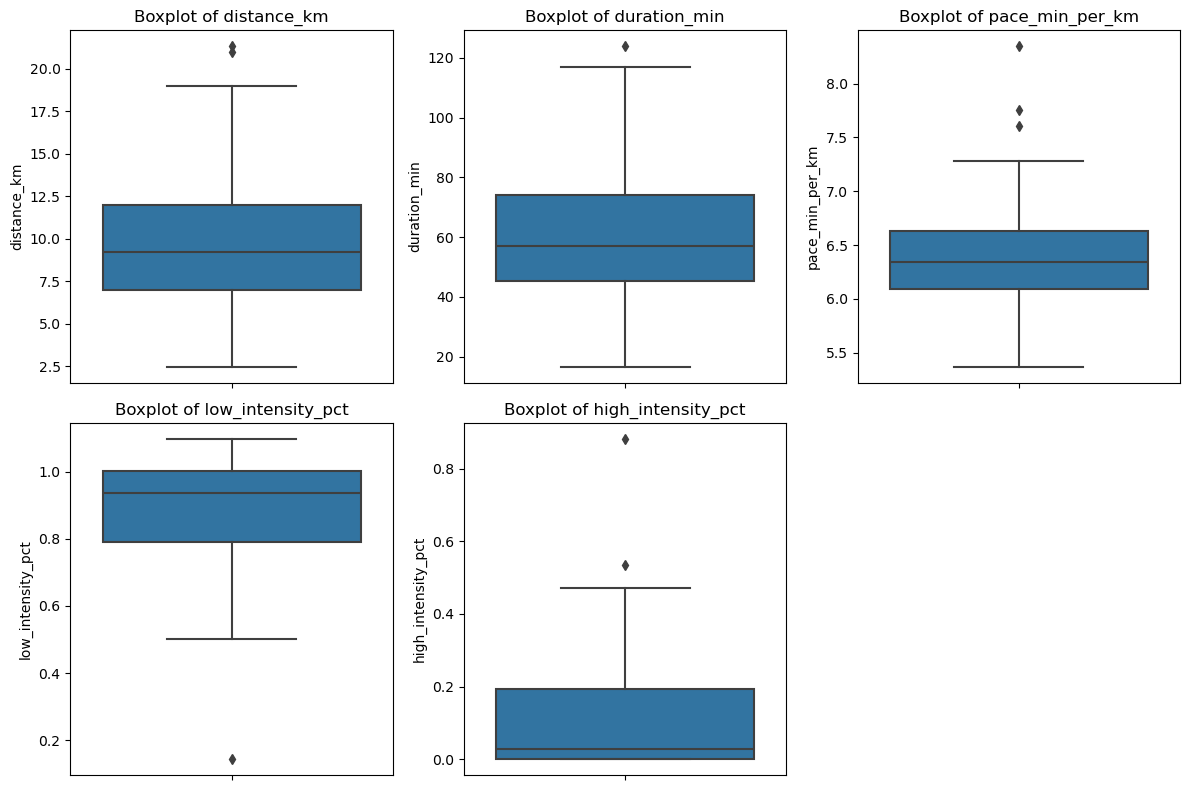

In [131]:
# visu la distribution des features to check outliers with boxplots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=sessions_filt[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

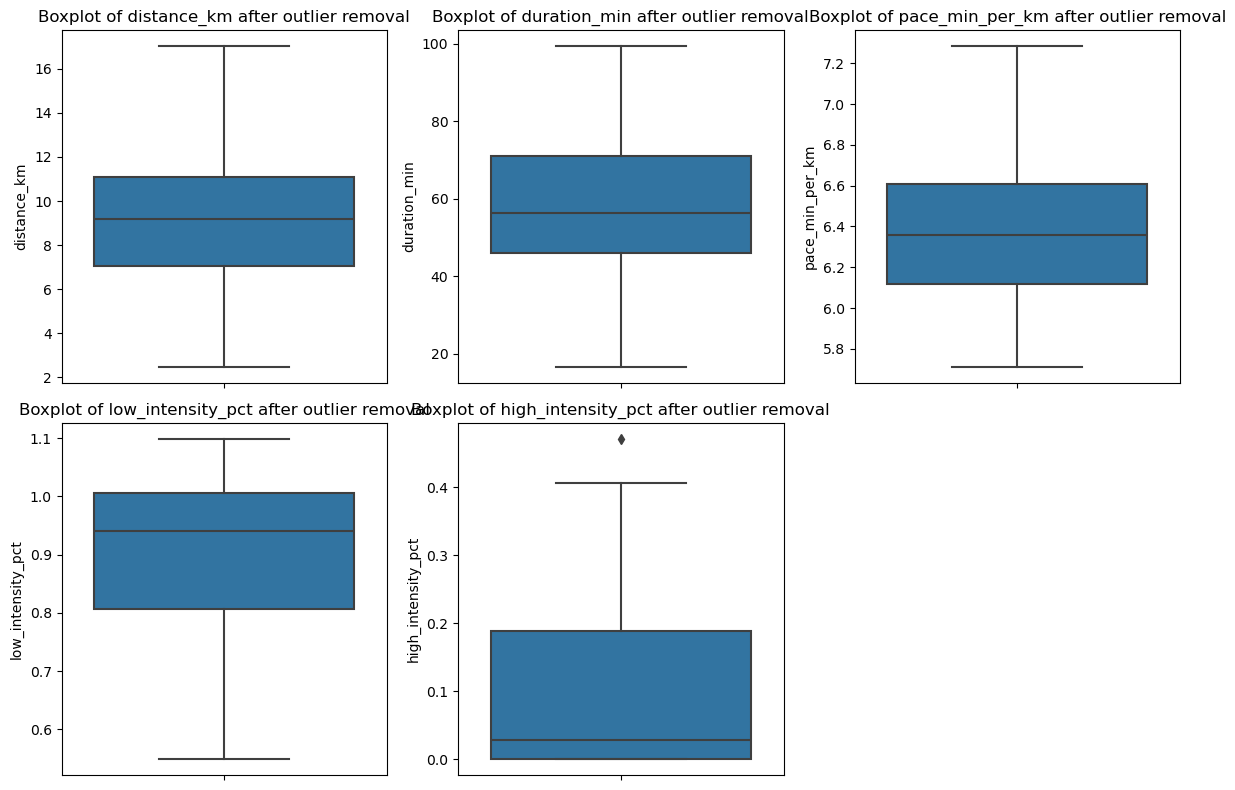

In [132]:
# supprimer les outliers
for feature in features:
    Q1 = sessions_filt[feature].quantile(0.25)
    Q3 = sessions_filt[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    sessions_filt = sessions_filt[
        (sessions_filt[feature] >= lower_bound) & (sessions_filt[feature] <= upper_bound)
    ]   
sessions_filt.reset_index(drop=True, inplace=True)
sessions_filt.shape
# visu les données après nettoyage
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=sessions_filt[feature])
    plt.title(f"Boxplot of {feature} after outlier removal")
plt.tight_layout()
plt.show()

   distance_km  duration_min  pace_min_per_km  low_intensity_pct  \
0    10.061551     61.306017         6.135378           0.675818   
1     6.568615     43.206532         6.608686           0.963885   
2    12.186898     75.851731         6.222201           0.946524   

   high_intensity_pct  
0            0.327271  
1            0.035427  
2            0.054499  


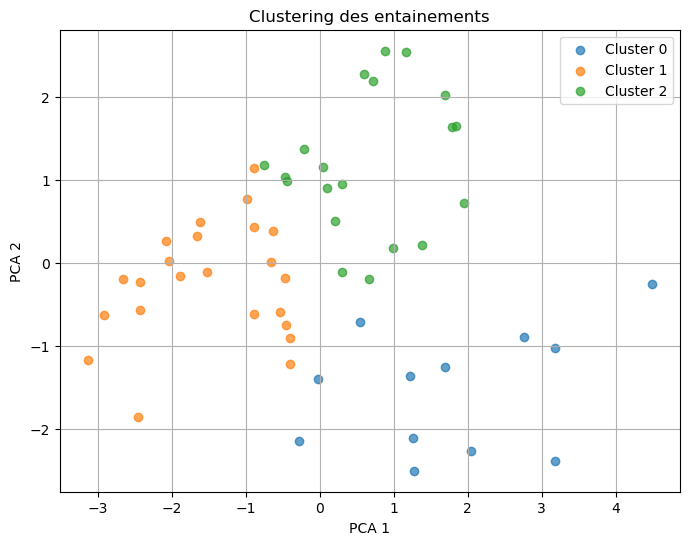

   cluster_session  min_distance_km  min_duration_min  min_pace  \
0                0         5.552773         35.601916  6.411556   
1                1         2.485247         16.633087  6.692731   
2                2         9.011691         53.155478  5.898502   

   max_distance_km  max_duration_min  max_pace  
0        17.022094         99.382084  5.838417  
1        10.010909         68.079288  6.800510  
2        15.260628         94.177650  6.171283  


In [133]:
X = sessions_filt[features].fillna(0)
# Normalization
scaler_sessions = StandardScaler()
X_scaled = scaler_sessions.fit_transform(X)

# 3-cluster KMeans
kmeans3_session = KMeans(n_clusters=3, random_state=42)
sessions_filt["cluster_session"] = kmeans3_session.fit_predict(X_scaled)

# Compute centroids
centroids_session = pd.DataFrame(
    scaler_sessions.inverse_transform(kmeans3_session.cluster_centers_),
    columns=features,
)

(
    sessions_filt[
        [
            "start_time",
            "distance_km",
            "duration_min",
            "pace_min_per_km",
            "cluster_session",
        ]
    ].head(),
    sessions_filt.shape,
    centroids_session,
)

print(centroids_session)

#----------------------------------------------
# Visu
#----------------------------------------------

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

sessions_filt["pca1"] = X_pca[:, 0]
sessions_filt["pca2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))

for c in sorted(sessions_filt["cluster_session"].unique()):
    subset = sessions_filt[sessions_filt["cluster_session"] == c]
    plt.scatter(subset["pca1"], subset["pca2"], label=f"Cluster {c}", alpha=0.7)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clustering des entainements")
plt.legend()
plt.grid(True)
plt.show()

# Compute min/max distance per cluster
rows = []
for c in sorted(sessions_filt["cluster_session"].unique()):
    cluster_df = sessions_filt[sessions_filt["cluster_session"] == c]
    min_idx = cluster_df["distance_km"].idxmin()
    max_idx = cluster_df["distance_km"].idxmax()
    rows.append(
        {
            "cluster_session": c,
            "min_distance_km": cluster_df.loc[min_idx, "distance_km"],
            "min_duration_min": cluster_df.loc[min_idx, "duration_min"],
            "min_pace": cluster_df.loc[min_idx, "pace_min_per_km"],
            "max_distance_km": cluster_df.loc[max_idx, "distance_km"],
            "max_duration_min": cluster_df.loc[max_idx, "duration_min"],
            "max_pace": cluster_df.loc[max_idx, "pace_min_per_km"],
        }
    )

summary_df = pd.DataFrame(rows)
print(summary_df)


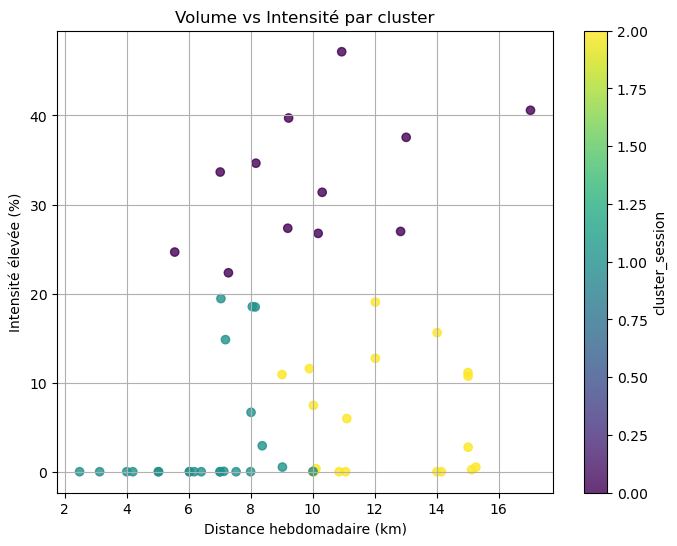

In [134]:
plt.figure(figsize=(8, 6))

plt.scatter(
    sessions_filt["distance_km"],
    sessions_filt["high_intensity_pct"] * 100,
    c=sessions_filt["cluster_session"],
    alpha=0.8,
)

plt.xlabel("Distance hebdomadaire (km)")
plt.ylabel("Intensité élevée (%)")
plt.title("Volume vs Intensité par cluster")
plt.colorbar(label="cluster_session")
plt.grid(True)
plt.show()


<Figure size 800x500 with 0 Axes>

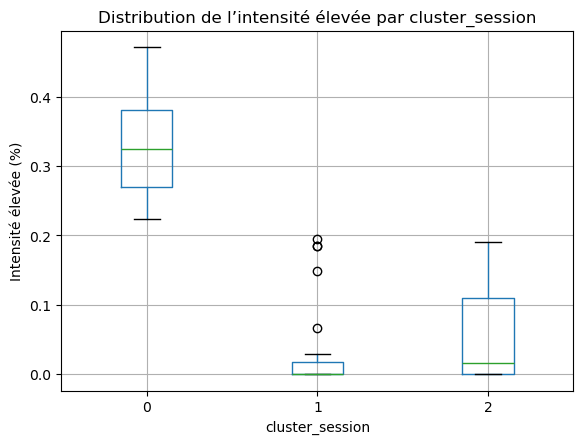

In [135]:
plt.figure(figsize=(8, 5))
sessions_filt.boxplot(column="high_intensity_pct", by="cluster_session", grid=True)

plt.suptitle("")
plt.title("Distribution de l’intensité élevée par cluster_session")
plt.xlabel("cluster_session")
plt.ylabel("Intensité élevée (%)")
plt.show()


<Figure size 800x500 with 0 Axes>

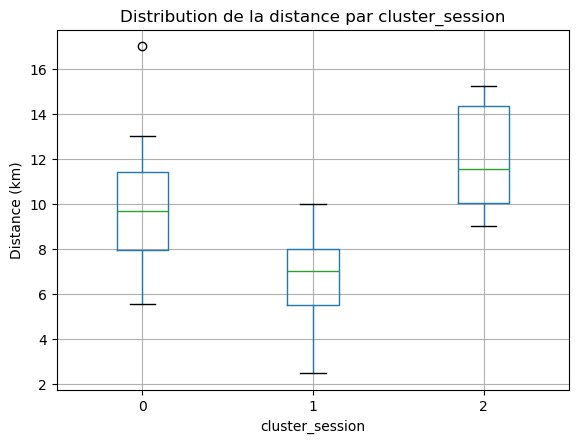

In [136]:
plt.figure(figsize=(8, 5))
sessions_filt.boxplot(column="distance_km", by="cluster_session", grid=True)

plt.suptitle("")
plt.title("Distribution de la distance par cluster_session")
plt.xlabel("cluster_session")
plt.ylabel("Distance (km)")
plt.show()


### quelques testes manuelles pour checker la logique

In [137]:
centroids_session

,distance_km,duration_min,pace_min_per_km,low_intensity_pct,high_intensity_pct
0,10.061551,61.306017,6.135378,0.675818,0.327271
1,6.568615,43.206532,6.608686,0.963885,0.035427
2,12.186898,75.851731,6.222201,0.946524,0.054499


In [138]:
joblib.dump(kmeans3_session, "models/kmeans3_session.joblib")
joblib.dump(scaler_sessions, "models/scaler_sessions.joblib")

['models/scaler_sessions.joblib']

# TEST : Clustering par SEMAINE avec le meme filtre sur les dates

In [139]:
week.head()

,user_id,year,iso_week,start_date,end_date,sessions_count,total_distance_km,total_duration_min,z1_z3_pct,z4_z5_pct,avg_load,created_at,iso_year
0,f90a87bf-2104-4456-8a54-b42c307337e7,2026,5,2026-01-26,2026-01-31,3,29.248084,180.274195,0.864951,0.135049,229.175576,2026-02-02 14:14:01.402095,2026
1,f90a87bf-2104-4456-8a54-b42c307337e7,2026,4,2026-01-20,2026-01-24,3,31.669952,202.032657,0.846277,0.153723,265.770008,2026-02-02 14:14:01.402095,2026
2,f90a87bf-2104-4456-8a54-b42c307337e7,2026,3,2026-01-13,2026-01-17,3,35.502520,219.547000,0.737889,0.262111,341.149175,2026-02-02 14:14:01.402095,2026
3,f90a87bf-2104-4456-8a54-b42c307337e7,2026,2,2026-01-05,2026-01-10,4,35.281388,230.093800,0.741197,0.258803,349.016364,2026-02-02 14:14:01.402095,2026
4,f90a87bf-2104-4456-8a54-b42c307337e7,2026,1,2025-12-30,2026-01-03,3,30.239698,186.267078,0.868636,0.131364,237.196638,2026-02-02 14:14:01.402095,2026


In [144]:
# rename columns for consistency
week = week.rename(
    columns={
        "total_distance_km": "distance_km",
        "total_duration_min": "duration_min",
        "sessions_count": "sessions",
        "z1_z3_pct": "low_intensity_pct",
        "z4_z5_pct": "high_intensity_pct",
        "avg_load": "weekly_load",
    }
)

Dataset prêt : (19, 13)
2025-09-09 00:00:00
19
Centroids des clusters de semaines :
   distance_km  sessions  duration_min  low_intensity_pct  high_intensity_pct  \
0    34.863404  3.166667    212.818649           0.714179            0.285821   
1    29.181188  3.250000    186.379311           0.930696            0.069304   
2     7.284365  1.000000     47.135469           0.780899            0.219101   

   weekly_load  
0   333.544220  
1   210.718825  
2    68.192143  

Aperçu des semaines :


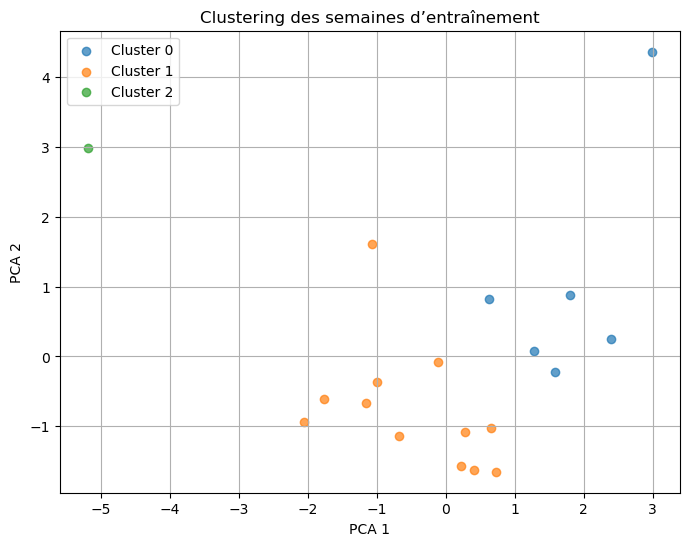

   cluster_week  min_distance_km  min_duration_min  max_distance_km  \
0             0        31.329185        189.049604        38.074161   
1             1        23.939647        148.198547        35.172801   
2             2         7.284365         47.135469         7.284365   

   max_duration_min  
0        233.007170  
1        229.361943  
2         47.135469  


In [148]:
week["start_date"] = pd.to_datetime(week["start_date"])
week = week[week["start_date"] >= "2025-09-08"].copy()

# Supprimer les semaines incomplètes si besoin
week = week.dropna(subset=["distance_km", "sessions", "duration_min"])

week = week[week["start_date"] >= "2025-09-08"].copy()

current_week_start = pd.Timestamp("2026-01-19")

week_clustering = (
    week.loc[week["start_date"] < current_week_start]
    .dropna(
        subset=[
            "distance_km",
            "sessions",
            "duration_min",
            "low_intensity_pct",
            "high_intensity_pct",
            "weekly_load",
        ]
    )
    .reset_index(drop=True)
)


week_clustering = week_clustering.reset_index(drop=True)
print("Dataset prêt :", week_clustering.shape)
print(week_clustering["start_date"].min())
print(len(week_clustering))
FEATURES = [
    "distance_km",
    "sessions",
    "duration_min",
    "low_intensity_pct",
    "high_intensity_pct",
    "weekly_load",
]

X = week_clustering[FEATURES].copy()
#normalize
scaler_week = StandardScaler()
X_scaled = scaler_week.fit_transform(X)

# 3-cluster KMeans
kmeans3_week = KMeans(n_clusters=3, random_state=42, n_init=20)
week_clustering["cluster_week"] = kmeans3_week.fit_predict(X_scaled)

# Compute centroids
centroids_week = pd.DataFrame(
    scaler_week.inverse_transform(kmeans3_week.cluster_centers_), columns=FEATURES
)

print("Centroids des clusters de semaines :")
print(centroids_week)

print("\nAperçu des semaines :")
week_clustering[
    ["start_date", "distance_km", "sessions", "duration_min", "cluster_week"]
].head()

joblib.dump(scaler_week, "models/scaler_week.joblib")
joblib.dump(kmeans3_week, "models/kmeans3_week.joblib")
#----------------------------------------------------------------
# visu
#----------------------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

week_clustering["pca1"] = X_pca[:, 0]
week_clustering["pca2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))

for c in sorted(week_clustering["cluster_week"].unique()):
    subset = week_clustering[week_clustering["cluster_week"] == c]
    plt.scatter(subset["pca1"], subset["pca2"], label=f"Cluster {c}", alpha=0.7)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clustering des semaines d’entraînement")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------------
# Compute min/max distance per cluster
# ----------------------------------------------------------------
rows = []
for c in sorted(week_clustering["cluster_week"].unique()):
    cluster_df = week_clustering[week_clustering["cluster_week"] == c]
    min_idx = cluster_df["distance_km"].idxmin()
    max_idx = cluster_df["distance_km"].idxmax()
    rows.append(
        {
            "cluster_week": c,
            "min_distance_km": cluster_df.loc[min_idx, "distance_km"],
            "min_duration_min": cluster_df.loc[min_idx, "duration_min"],
            "max_distance_km": cluster_df.loc[max_idx, "distance_km"],
            "max_duration_min": cluster_df.loc[max_idx, "duration_min"],
        }
    )

summary_df = pd.DataFrame(rows)
print(summary_df)

week = week.merge(
    week_clustering[["start_date", "cluster_week"]], on="start_date", how="left"
)


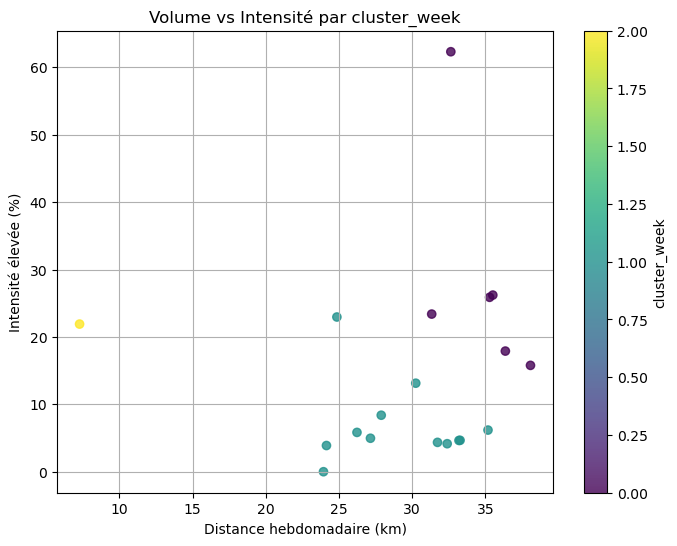

In [149]:
plt.figure(figsize=(8, 6))

plt.scatter(
    week_clustering["distance_km"],
    week_clustering["high_intensity_pct"] * 100,
    c=week_clustering["cluster_week"],
    alpha=0.8,
)

plt.xlabel("Distance hebdomadaire (km)")
plt.ylabel("Intensité élevée (%)")
plt.title("Volume vs Intensité par cluster_week")
plt.colorbar(label="cluster_week")
plt.grid(True)
plt.show()


In [150]:
centroids_week

,distance_km,sessions,duration_min,low_intensity_pct,high_intensity_pct,weekly_load
0,34.863404,3.166667,212.818649,0.714179,0.285821,333.544220
1,29.181188,3.250000,186.379311,0.930696,0.069304,210.718825
2,7.284365,1.000000,47.135469,0.780899,0.219101,68.192143


# Liaisons

Dans cette partie, nous allons étudier differentes liaisons possible afin d'affiner notre idée de recommandation.

## Liaison causale
Ici nous allons étidier la question : "Pourquoi une semaine est dans un cluster donné ?"

L'objectif est de montrer que les clusters hebdomadaires sont expliqués par la composition des séances.

RAPPEL

| cluster séance | réalité                                                        |
| -------------- | -------------------------------------------------------------- |
| **0**          | séances **intensives**                  |
| **1**          | séances **faciles** |
| **2**          | séances **d’endurance**                 |
           



| cluster semaine | réalité                                                               |
| --------------- | --------------------------------------------------------------------- |
| **0**           | semaine **intense** *(volume + intensité élevés)*                     |
| **1**           | semaine **déséquilibrée / très allégée** *(contrainte, reprise, off)* |
| **2**           | semaine **maîtrisée / endurance** *(socle aérobie)*                   |


In [152]:
# 1 - Ajouter la semaine "week_start" aux séances sessions_filt
# Pour chaque séance, on prend sa date, la convertis en semaine calendaire, récupères le début de cette semaine
sessions_filt["start_date"] = (
    sessions_filt["date"].dt.to_period("W").apply(lambda r: r.start_time)
)

KeyError: 'date'

In [ ]:
# 2 - distribution hebdomadaire des clusters
# Distribution des clusters de séances par semaine : 1 ligne = 1 semaine
# 1 ligne = 1 semaine
# 2 - distribution hebdomadaire des clusters de séances
# 1 ligne = 1 semaine

week_sessions_profile = (
    sessions_filt.groupby("week_start")["cluster_session"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .rename(
        columns={
            0: "intensive_pct",  
            1: "easy_pct", 
            2: "endurance_pct",  
        }
    )
    .rename_axis(None, axis=1)
    .reset_index()
)

week_sessions_profile.tail()


,week_start,intensive_pct,easy_pct,endurance_pct
14,2025-12-15,0.000000,0.333333,0.666667
15,2025-12-22,0.000000,1.000000,0.000000
16,2025-12-29,0.666667,0.333333,0.000000
17,2026-01-05,0.250000,0.500000,0.250000
18,2026-01-12,0.666667,0.333333,0.000000


le tableau represente POUR CHAQUE SEMAINE, la composition interne en types de séances

- Semaine du 2026-01-12

66 % de séances intensives

33 % de sorties faciles / récupération

0 % de sorties d’endurance

Semaine très orientée intensité, avec un minimum de facile pour absorber la charge, mais absence d’endurance continue.


In [ ]:
# 3 - on fusionne les deux datasets
# chaque ligne = 1 semaine
# avec : ses caractéristiques globales (km, charge, etc.) & sa structure interne (% des types de séances)

df_linked = week.merge(week_sessions_profile, on="week_start", how="left")

df_linked.head()

# 4 - on fait la moyenne des zones par cluster
df_linked.groupby("cluster_week")[
    ["intensive_pct", "easy_pct", "endurance_pct"]
].mean().round(2)

,intensive_pct,easy_pct,endurance_pct
cluster_week,,,
0.0,0.48,0.22,0.31
1.0,0.00,1.00,0.00
2.0,0.20,0.42,0.39


RAPPEL

| cluster séance | réalité                                                        |
| -------------- | -------------------------------------------------------------- |
| **0**          | séances **intensives**                  |
| **1**          | séances **faciles** |
| **2**          | séances **d’endurance**                 |
           



| cluster semaine | réalité                                                               |
| --------------- | --------------------------------------------------------------------- |
| **0**           | semaine **intense** *(volume + intensité élevés)*                     |
| **1**           | semaine **déséquilibrée / très allégée** *(contrainte, reprise, off)* |
| **2**           | semaine **maîtrisée / endurance** *(socle aérobie)*                   |


Les variables easy_pct, endurance_pct et intensity_pct décrivent la proportion de chaque type de séance au sein d’une semaine et permettent d’expliquer l’appartenance d’une semaine à un cluster donné.

🔴 Cluster week 0 — Semaines intensives
- ≈ 48 % de séances intensives (cluster séance 0)
- ≈ 31 % de séances d’endurance (cluster séance 2)
- ≈ 22 % de séances faciles (cluster séance 1)
- Intensité fortement présente, mais partiellement compensée par du volume aérobie
- Interprétation : Semaines exigeantes, à fort stress physiologique, structurées autour de plusieurs séances intensives, avec un minimum d’endurance pour absorber la charge.
- Rôle RS : Cluster de charge élevée → nécessite récupération ou semaine plus modérée ensuite.

🟡 Cluster week 1 — Semaines déséquilibrées / très allégées
- 100 % de séances faciles
- 0 % intensité
- 0 % endurance structurée
- Interprétation : Semaines très allégées, souvent liées à récupération, reprise ou contrainte externe (temps, fatigue, indisponibilité).
- Rôle RS : Cluster de pause / récupération : utile ponctuellement, non progressif s’il se prolonge.

🟢 Cluster week 2 — Semaines modérées / maîtrisées
- ≈ 42 % de séances faciles
- ≈ 39 % de séances d’endurance
- ≈ 20 % de séances intensives
- Intensité présente mais minoritaire
- Interprétation : Semaines bien équilibrées, majoritairement orientées endurance et récupération, avec une touche d’intensité suffisante pour entretenir le stimulus.
- Rôle RS : Cluster socle : idéal pour construire, stabiliser la charge et préparer une montée en intensité.

## Liaison décisionnelle
Ici, le but est d'explorer la question : "Que recommander maintenant ?". Nous allons construire les transitions entre clusters de semaines

In [ ]:
df_week_sorted = (
    week[week["cluster_week"].notna()]  # uniquement semaines complètes
    .sort_values("week_start")
    .copy()
)

df_week_sorted["next_cluster_week"] = df_week_sorted["cluster_week"].shift(-1)

# Le but : observer ce qui arrive APRÈS une semaine donnée, pas le deviner.
# On cherche à analyser des enchaînements passés pour en tirer des règles.
# cluster = cluster de la semaine courante
# next_cluster = cluster de la semaine suivante

idee :

Chaque semaine est maintenant attribué a un cluster :    
- Semaine 1 => cluster = 0      
- Semaine 2 => cluster = 1   
- Semaine 3 => cluster = 0  

Nous pouvons donc tracer les liens entre la semaine X avec son cluster Cx et la semaine X+1 avec sont cluster Cx+1
- Semaine 1 => cluster = 0 => next_cluster = 1       
- Semaine 2 => cluster = 1 => next_cluster = 0          
- Semaine 3 => cluster = 0 => next_cluster = cluster de la semaine 4        

In [ ]:
# On construit une matrice de transition :
# lignes = cluster de la semaine actuelle
# colonnes = cluster de la semaine suivante
# valeurs = probabilités conditionnelles

transition_matrix = pd.crosstab(
    df_week_sorted["cluster_week"],
    df_week_sorted["next_cluster_week"],
    normalize="index",
).round(2)

transition_matrix  # matrice de transition = chaîne de Markov empirique, à voir et à se renseigner dessus si le temps le permet ????????????


# crosstab :
# Crée un tableau de contingence entre deux variables catégorielles :
# lignes (A) → cluster : le cluster de la semaine courante
# colonnes (B) → next_cluster : le cluster de la semaine suivante
# Chaque cellule compte combien de fois on observe la transition : semaine de type A → semaine de type B

# normalize="index" : Pour chaque cluster actuel, on normalise par le total de la ligne.
# Résultat : chaque ligne somme à 1, les valeurs sont des probabilités conditionnelles

# Cette matrice décrit ce qui arrive en moyenne la semaine suivante, en fonction du type de la semaine actuelle.
# On lit toujours par ligne, jamais par colonne.

next_cluster_week,0.0,1.0,2.0
cluster_week,,,
0.0,0.56,0.00,0.44
1.0,1.00,0.00,0.00
2.0,0.38,0.12,0.50


La matrice de transition décrit les probabilités conditionnelles de passage d’un type de semaine à un autre. 

Elle met en évidence des dynamiques d’enchaînement, notamment un risque d’accumulation de charge après des semaines intensives ou déséquilibrées.

🔴 Cluster semaine 0 — Semaine intensive / charge élevée
- cluster_week 0 → 0 : 56 %       
- cluster_week 0 → 2 : 44 %     
- cluster_week 0 → 1 : 0 %   

- Plus d’une semaine intensive sur deux est suivie par une autre semaine intensive.
- Le reste des cas bascule vers une semaine modérée (comportement plus sain).
- Aucune transition directe vers une semaine déséquilibrée.

Interprétation
- Forte tendance à l’enchaînement de charge élevée.
- Capacité partielle à redescendre vers une semaine maîtrisée, mais pas systématique.

Point de vigilance
- Risque d’accumulation de fatigue si plusieurs semaines intensives s’enchaînent.

🟡 Cluster semaine 1 — Semaine déséquilibrée / très allégée
- cluster_week 1 → 0 : 100 %   
- cluster_week 1 → 1 : 0 %      
- cluster_week 1 → 2 : 0 %       

- Une semaine déséquilibrée est toujours suivie d’une semaine intensive.
- Aucune transition vers une semaine modérée ou de reprise progressive.
- Pas de montée progressive
- Charge brutale après une rupture de continuité

Point clé 
- Il y a un risque d’accumulation de charge.


🟢 Cluster semaine 2 — Semaine modérée / maîtrisée

-  cluster_week 2 → 2 : 50 %
- cluster_week 2 → 0 : 38 %
- cluster_week 2 → 1 : 12 %

- 1 semaine modérée sur 2 reste stable (très bon signal).
- Une part non négligeable bascule vers une semaine intensive.
- Faible dérive vers des semaines déséquilibrées.

Interprétation coach
- La semaine modérée est le meilleur état d’équilibre du système.
- Elle permet soit la stabilisation, soit une montée en charge contrôlée.
- Les dérives vers le déséquilibre sont rares et probablement liées à des contraintes externes.

# Recommandations

Nous allons maintenant étudier les possibilité de recommandation plus en détail. L'idée est de recommander en fonction d’une tendance récente (3 semaines par exemple)

In [ ]:
week_session_clusters = (
    sessions_filt.sort_values("date") 
    .groupby("week_start")["cluster_session"]
    .apply(list)
    .reset_index(name="session_clusters")
)

today = pd.Timestamp.today().normalize()
current_week_start = today - pd.to_timedelta(today.weekday(), unit="D")

completed_weeks = df_week_sorted[df_week_sorted["week_start"] < current_week_start]
last_3w = completed_weeks.tail(3)

# Cluster dominant sur 3 semaines
if last_3w["cluster_week"].notna().any():
    dominant_cluster = last_3w["cluster_week"].mode().iloc[0]
else:
    dominant_cluster = None

# Tendance de charge
trend_km = last_3w["distance_km"].iloc[-1] - last_3w["distance_km"].iloc[0]

# Moyenne des séances / semaine
avg_sessions = last_3w["sessions"].mean()  # On calcule la moyenne des séances sur les 3 semaines 

# Intensité moyenne récente
avg_intensity = last_3w["high_intensity_pct"].mean()

last_3w = last_3w.merge(week_session_clusters, on="week_start", how="left")
for col in ["intensive_pct", "easy_pct", "endurance_pct"]:
    if col not in df_linked.columns:
        df_linked[col] = 0.0
    else:
        df_linked[col] = df_linked[col].fillna(0.0)


last_3w.head()


,week_start,week_end,distance_km,sessions,duration_min,low_intensity_pct,high_intensity_pct,variation_km,longest_run_km,weekly_load,...,sig_weekly_std_km,sig_trend_12w_pct,sig_z4_z5_avg_pct,sig_z4_z5_trend_12w_pct,sig_acwr_avg,sig_acwr_max,sig_load_std_trend_12w_pct,cluster_week,next_cluster_week,session_clusters
0,2025-12-29,2026-01-05,30.239698,3,186.267078,0.559898,0.440102,22.955333,15.008056,268.243614,...,8.600497,0.08342,0.293369,54.65862,1.097481,1.491224,15.745134,0.0,0.0,"[1, 0, 0]"
1,2026-01-05,2026-01-12,35.281388,4,230.093800,0.541371,0.458629,5.041690,17.022094,335.621439,...,8.600497,0.08342,0.293369,54.65862,1.097481,1.491224,15.745134,0.0,0.0,"[1, 2, 1, 0]"
2,2026-01-12,2026-01-19,35.502520,3,219.547000,0.505325,0.494675,0.221132,19.013623,328.151493,...,8.600497,0.08342,0.293369,54.65862,1.097481,1.491224,15.745134,0.0,NaN,"[0, 1, 0]"


In [ ]:
def recommend_week_plan(last_3w):
    dominant_cluster = last_3w["cluster_week"].mode()[0]
    avg_sessions = round(last_3w["sessions"].mean())
    avg_sessions = max(2, min(avg_sessions, 5))

    if dominant_cluster == 1:  # semaine intensive
        return {"sessions": avg_sessions, "plan": ["easy", "easy", "endurance"]}

    if dominant_cluster == 2:  # semaine courte / déséquilibrée
        return {"sessions": max(2, avg_sessions - 1), "plan": ["easy", "easy"]}

    return {"sessions": avg_sessions, "plan": ["easy", "endurance", "intensity"]}

Cette fonction est une premiere idée de recommandation brute. En effet, on "hard code" un peu ici les suppositions en fonction du cluster dominant des 3 dernieres semaines.

Nous nous sommes basé sur un systeme logique. 
- Si le coureur a eu comme cluster dominant sur les 3 dernieres semaines "semaine intense", alors la recommandation est quelque chose de plus tranquille avec du run easy (court et en tres basse intensité), et du run endurence (court et majorité basse intensité). Dans ce cas, le nombre de seance est le nombre de seance moyenne du coureur.
- Si les 3 dernieres semaines etaient déséquilibrées, on recommande des run faciles pour la reprise. Avec un nombre de seance entre 2 et sa moyenne de seance-1.
- Si les 3 dernieres semaines etaient modéré, on recommande un peu d'intensité en plus de seance facile et de seance en endurence

In [ ]:
print("📅 Semaines utilisées pour la recommandation :")
last_3w[
    [
        "week_start",
        "cluster_week",
        "distance_km",
        "sessions",
        "high_intensity_pct",
    ]
]

📅 Semaines utilisées pour la recommandation :


,week_start,cluster_week,distance_km,sessions,high_intensity_pct
0,2025-12-29,0.0,30.239698,3,0.440102
1,2026-01-05,0.0,35.281388,4,0.458629
2,2026-01-12,0.0,35.502520,3,0.494675


Donc, sur ces 3 semaines :
- Les clusters de semaines observés sont : [1, 0, 0], soit une semaine déséquilibrée, suivie de deux semaines intensives consécutives.

- Les nombres de séances observés sont : [1, 3, 4], montrant une forte montée en charge après une semaine très allégée.


In [ ]:
current_week_sessions = sessions_filt[sessions_filt["week_start"] == current_week_start]
SESSION_LABELS = {
    0: "intensity",
    1: "easy",
    2: "endurance",
}
current_week_sessions.head()

,date,distance_km,duration_min,z1_min,z2_min,z3_min,z4_min,z5_min,pace_min_per_km,low_intensity_pct,high_intensity_pct,cluster_session,pca1,pca2,week_start


Parfois, la seance courante peut avoir une seance déjà faite par le coureur. La recommandation etant basé sur la semaine actuelle, c'est important de prendre en compte si le coureur a déjà réalisé une seance ou non afin d'ajuster la recommandation.

In [ ]:
# Afficher la semaine en cours (analyse partielle)

current_week = df_week_sorted[df_week_sorted["week_start"] == current_week_start]

done_types = current_week_sessions["cluster_session"].map(SESSION_LABELS).tolist()

print(done_types)
print("📊 Semaine en cours (partielle) :")
current_week[
    ["week_start", "sessions", "distance_km", "high_intensity_pct", "cluster_week"]
]

# quand current_week est vide il y a pas de seances de faites

[]
📊 Semaine en cours (partielle) :


,week_start,sessions,distance_km,high_intensity_pct,cluster_week


In [ ]:
# Générer la recommandation hebdomadaire
recommendation = recommend_week_plan(last_3w)

print("🧠 Recommandation brute :")
recommendation


🧠 Recommandation brute :


{'sessions': 3, 'plan': ['easy', 'endurance', 'intensity']}

In [ ]:
total_sessions_recommended = recommendation["sessions"]
sessions_done = len(done_types)

remaining_sessions = max(0, total_sessions_recommended - sessions_done)

In [ ]:
def adjust_plan(plan, done_types, remaining_sessions):
    plan_copy = plan.copy()

    # Retirer une occurrence de chaque type déjà fait
    for done in done_types:
        if done in plan_copy:
            plan_copy.remove(done)

    # Garder seulement le nombre de séances restantes
    adjusted = plan_copy[:remaining_sessions]

    # Compléter si nécessaire avec des séances faciles
    while len(adjusted) < remaining_sessions:
        adjusted.append("easy")

    return adjusted


In [ ]:
# Adapter la reco à la semaine en cours (clé)
# ajustement en fonction de ce qui est déjà fait.
# Nombre de séances déjà réalisées cette semaine

if current_week.empty:
    sessions_done = 0
else:
    sessions_done = int(current_week["sessions"].fillna(0).iloc[0])

remaining_sessions = max(0, recommendation["sessions"] - sessions_done)

adjusted_plan = adjust_plan(recommendation["plan"], done_types, remaining_sessions)

print("🛠 Plan ajusté pour le reste de la semaine :")
adjusted_plan


🛠 Plan ajusté pour le reste de la semaine :


['easy', 'endurance', 'intensity']

Le nombre moyen de seance etant egale a 3, et les 3 seances etant deja réalisés, la recommandation reste vide car le coureur a deja fait ce qu'il fallait faire

In [ ]:
# Générer le message final (chatbot-ready)
def generate_message(last_3w, recommendation, adjusted_plan):
    dominant_cluster = last_3w["cluster_week"].mode()[0]

    labels = {
        0: "semaine maîtrisée",
        1: "semaine intensive",
        2: "semaine courte et déséquilibrée",
    }

    return (
        f"Sur les trois dernières semaines complètes, ton entraînement correspond à une "
        f"{labels[dominant_cluster]}. "
        f"Je te recommande {recommendation['sessions']} séances cette semaine, "
        f"dont principalement : {', '.join(recommendation['plan'])}. "
        f"Il te reste {len(adjusted_plan)} séance(s) à réaliser cette semaine : "
        f"{', '.join(adjusted_plan)}."
    )


print("💬 Message final :")
print(generate_message(last_3w, recommendation, adjusted_plan))


💬 Message final :
Sur les trois dernières semaines complètes, ton entraînement correspond à une semaine maîtrisée. Je te recommande 3 séances cette semaine, dont principalement : easy, endurance, intensity. Il te reste 3 séance(s) à réaliser cette semaine : easy, endurance, intensity.


C'etait une premiere idée de recommandation. Celle ci ce base sur une fonction assez strict en fonction du cluster domminant des 3 dernieres semaines et du nombre moyen de seance.

# Recommandation - Niveau 2

L’idée clé
- Les types de séances recommandés sont ceux que l’on observe habituellement dans les semaines similaires.

Autrement dit :
- on ne décide PAS “à la main” (donc différent que la recommandation précedente)
- on copies la structure moyenne des semaines du même cluster_week

Le clustering sert à extraire des templates de semaine.

DONNÉES DE DÉPART
- sessions_filt : session_cluster , week_start, date
- df_sorted (ou week) : week_cluster, week_start

### 1 - Construire la distribution des séances par cluster de semaine

On veut calculer : P(session_cluster ∣ week_cluster)

In [ ]:
# Étape 1 — Compter les séances par semaine
week_session_counts = (
    sessions_filt.groupby(["week_start", "cluster_session"])
    .size()
    .reset_index(name="n_sessions")
)

# Étape 2 — Ajouter le cluster_week correspondant
week_session_counts = week_session_counts.merge(
    df_week_sorted[["week_start", "cluster_week"]], on="week_start", how="left"
)

# Étape 3 — Calculer la distribution moyenne par cluster_week
cluster_session_distribution = (
    week_session_counts.groupby(["cluster_week", "cluster_session"])["n_sessions"]
    .mean()
    .reset_index()
)

# Étape 4 — Normaliser pour obtenir des pourcentages
cluster_session_distribution["pct"] = cluster_session_distribution.groupby(
    "cluster_week"
)["n_sessions"].transform(lambda x: x / x.sum())

cluster_session_distribution

,cluster_week,cluster_session,n_sessions,pct
0,0.0,0,1.555556,0.400000
1,0.0,1,1.166667,0.300000
2,0.0,2,1.166667,0.300000
3,1.0,1,1.000000,1.000000
4,2.0,0,1.000000,0.241379
5,2.0,1,1.714286,0.413793
6,2.0,2,1.428571,0.344828


RAPPEL

| cluster séance | réalité                                                        |
| -------------- | -------------------------------------------------------------- |
| **0**          | séances **intensives**                  |
| **1**          | séances **faciles** |
| **2**          | séances **d’endurance**                 |
           



| cluster semaine | réalité                                                               |
| --------------- | --------------------------------------------------------------------- |
| **0**           | semaine **intense** *(volume + intensité élevés)*                     |
| **1**           | semaine **déséquilibrée / très allégée** *(contrainte, reprise, off)* |
| **2**           | semaine **maîtrisée / endurance** *(socle aérobie)*                   |


- n_sessions : Nombre moyen de séances de ce type par semaine, pour les semaines de ce cluster.
- pct = proportion relative de chaque type de séance dans une semaine typique de ce cluster
- pct= n_sessions/ ∑n_sessions du cluster

Exemple pour cluster_week = 0 (semaine dite intense) :
- total de seance ≈ 1.55 +  1.17 + 1.17 ≈ 3.89 seances
- cluster seance = 1 : seance intensity → 1.55 / 3.89 ≈ 40 % => pct pour cluster_week=0 & cluster_session =0
- cluster seance = 1 : seance easy → 30 % => pct pour cluster_week=0 & cluster_session =1
- cluster seance = 2 : endurance → 30 % => pct pour cluster_week=0 & cluster_session =2

pct est une distribution de probabilité empirique, c'est un peu la signature du cluster

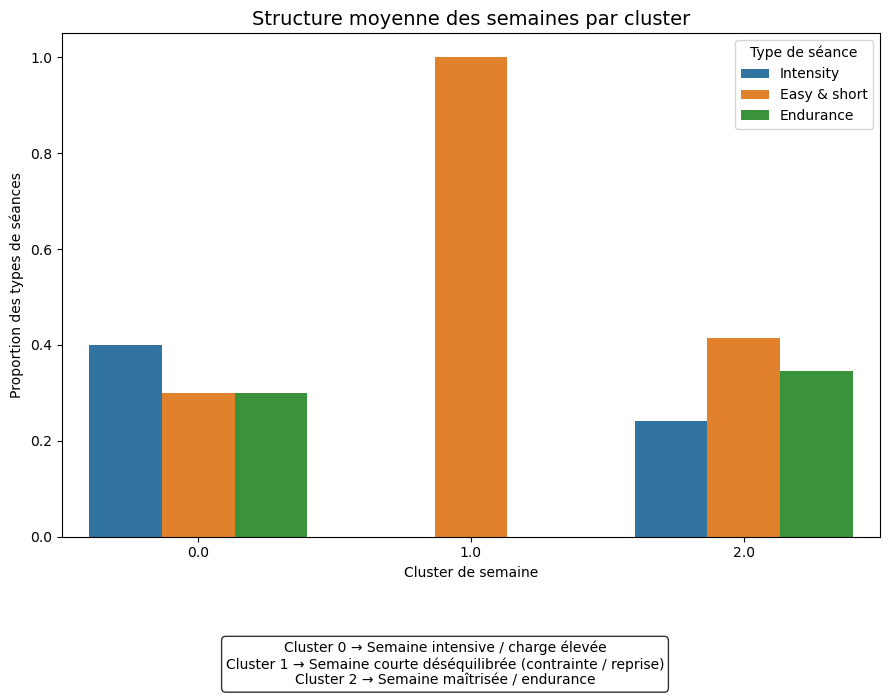

In [ ]:
# Mapping lisible des clusters de séances
SESSION_LABELS = {
    0: "Intensity",
    1: "Easy & short",
    2: "Endurance",
}

cluster_session_distribution["session_type"] = cluster_session_distribution[
    "cluster_session"
].map(SESSION_LABELS)

plt.figure(figsize=(9, 6))

sns.barplot(
    data=cluster_session_distribution, x="cluster_week", y="pct", hue="session_type"
)

plt.title("Structure moyenne des semaines par cluster", fontsize=14)
plt.ylabel("Proportion des types de séances")
plt.xlabel("Cluster de semaine")
plt.legend(title="Type de séance")

# Annotation explicative des clusters semaines
cluster_descriptions = (
    "Cluster 0 → Semaine intensive / charge élevée\n"
    "Cluster 1 → Semaine courte déséquilibrée (contrainte / reprise)\n"
    "Cluster 2 → Semaine maîtrisée / endurance"
)

plt.figtext(
    0.5,
    -0.15,
    cluster_descriptions,
    ha="center",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()


### 2 - Transformer cette distribution en “template de semaine”

In [ ]:
# Mapping clair
SESSION_LABELS = {
    0: "intensity",
    1: "easy",
    2: "endurance",
}
# Fonction pour créer un template à partir d’un cluster_week
def build_week_template(cluster_week, avg_sessions, distribution_df):
    rows = distribution_df[distribution_df["cluster_week"] == cluster_week]

    plan = []

    for _, row in rows.iterrows():
        n = round(row["pct"] * avg_sessions)
        plan += [SESSION_LABELS[row["cluster_session"]]] * n

    # Ajustement si arrondis
    while len(plan) < avg_sessions:
        plan.append("easy")
    while len(plan) > avg_sessions:
        plan.pop()

    return plan

# Identifier la dynamique récente (3 semaines complètes)
dominant_cluster = last_3w["cluster_week"].mode()[0]
avg_sessions = round(last_3w["sessions"].mean())
avg_sessions = max(2, min(avg_sessions, 5))
print(dominant_cluster)
print(avg_sessions)

0.0
3


Sur les 3 dernières semaines complètes, quel est le profil dominant ?  
- On voit que c'est le cluster_week = 0 (intensity). Cela represente les semaines intensive. En effet, ces dernieres semaines, les seances de course a pied du coureur sont assez intenses (monté en charge).   
- 3 seances en moyennes pour le coureur

### 3 - Générer la recommandation de la semaine

In [ ]:
recommended_plan = build_week_template(
    cluster_week=dominant_cluster,
    avg_sessions=avg_sessions,
    distribution_df=cluster_session_distribution,
)

recommendation = {"sessions": avg_sessions, "plan": recommended_plan}

print("🧠 Recommandation basée sur le clustering :")
recommendation


🧠 Recommandation basée sur le clustering :


{'sessions': 3, 'plan': ['intensity', 'easy', 'endurance']}

Calcul implicite `build_week_template`:     
On donne a la fonction le cluster dominant des 3 dernieres semaines (ici dominant_cluster = 1) & le nombre moyen de seance (donc 3) :
on re utilise le tableau cluster_session_distribution afin de l'adapter a notre cas:


| Type      | pct  | pct × 3 (row["pct"] * avg_sessions) | arrondi round(row["pct"] * avg_sessions)|
| --------- | ---- | ------- | ------- |
| intensity | 0.40 | 1.2    | 1       |
| easy      | 0.30 | 0.9    | 1       |
| endurance | 0.30 | 0.9    | 1       |

On obtent donc une part égale des 3 différentes seances (les 3 differents types de cluster_session).

Donc la recommandation sera dans ce cas : ['intensity', 'easy', 'endurance']

c’est une projection du cluster sur 3 séances.

In [ ]:
# Ajuster avec les séances déjà réalisées (semaine en cours)
current_week_sessions = sessions_filt[sessions_filt["week_start"] == current_week_start]
done_types = current_week_sessions["cluster_session"].map(SESSION_LABELS).tolist()

print("seance deja faites:", done_types)


# Ajustement intelligent en fonction de ce qu'on a deja courru
def adjust_plan(plan, done_types, remaining_sessions):
    plan_copy = plan.copy()

    for done in done_types:
        if done in plan_copy:
            plan_copy.remove(done)

    adjusted = plan_copy[:remaining_sessions]

    while len(adjusted) < remaining_sessions:
        adjusted.append("easy")

    return adjusted

remaining_sessions = max(0, recommendation["sessions"] - len(done_types))

adjusted_plan = adjust_plan(recommendation["plan"], done_types, remaining_sessions)

print("🛠 Plan ajusté :")
adjusted_plan


seance deja faites: []
🛠 Plan ajusté :


['intensity', 'easy', 'endurance']

Comme lors de la recommandation niveau 1, il faut prendre en compte si le coureur a deja couru cette semaine. Il faut donc ajuster la recommandation si c'est le cas.

# TENTATIVE de “RISQUE”

Nous pouvons maintenant faire de la recommandation dynamique de type de seance en fonction des 3 dernieres semaines et de l'habitude du nombre de seance du coureur. Cette recommandation est faire par similarité au coureur lui meme. Mais, imaginons que nous faisons que recommander les seances de type "intensity", que va il se passer? Le coueur sera amener a se blesser.

On ne va PAS prédire les blessures.

Ce qu’on va essayer de prédire est le risque de semaine problématique à court terme.

Concrètement, nous allons utiliser les indices de surcharge, déséquilibre, rupture de régularité....

In [ ]:
def is_risky_week(row):
    if row["cluster_week"] == 0:  # semaine intensive
        return 1
    if row["weekly_load"] > load_threshold:
        return 1
    if row["high_intensity_pct"] > 0.45:
        return 1
    return 0

La fonction construit une étiquette binaire risk pour chaque semaine :
- risk = 1 -> semaine considérée à risque
- risk =0 -> semaine sans risque

C'est des règles métiers (“simplifiée”) pour marquer certaines semaines comme potentiellement risquées.

- Règle 1 -> cluster_week == 0 (semaine intensive) : 
    - si la semaine appartient au cluster “intensive / charge élevée”, alors elle est à risque.

- Règle 2 -> weekly_load > load_threshold (charge au-dessus d’un percentile)
    - weekly_load : indicateur synthétique de charge.
    - load_threshold = un seuil statistique calculé sur les données (les 20% semaines les plus “chargées” = à risque)

- Règle 3 -> high_intensity_pct > 0.45 (trop d’intensité)
    - high_intensity_pct = part de temps (ou volume) en intensité élevée sur la semaine.
    - Seuil 0.45 (45%) : on considère qu’au-delà, la semaine est trop orientée intensité.

### Construire le dataset ML (X, y)

In [ ]:
df_ml = df_week_sorted.copy()
df_ml.head()

,week_start,week_end,distance_km,sessions,duration_min,low_intensity_pct,high_intensity_pct,variation_km,longest_run_km,weekly_load,sig_weekly_avg_km,sig_weekly_std_km,sig_trend_12w_pct,sig_z4_z5_avg_pct,sig_z4_z5_trend_12w_pct,sig_acwr_avg,sig_acwr_max,sig_load_std_trend_12w_pct,cluster_week,next_cluster_week
0,2025-09-08,2025-09-15,31.725308,4,203.202304,0.647579,0.352421,1.785732,8.145728,274.815049,27.716679,8.600497,0.08342,0.293369,54.65862,1.097481,1.491224,15.745134,0.0,0.0
1,2025-09-15,2025-09-22,24.854587,2,158.394251,0.553832,0.446168,-6.870721,12.835037,229.064674,27.716679,8.600497,0.08342,0.293369,54.65862,1.097481,1.491224,15.745134,0.0,2.0
2,2025-09-22,2025-09-29,35.172801,3,229.361943,0.794979,0.205021,10.318214,14.149791,276.385871,27.716679,8.600497,0.08342,0.293369,54.65862,1.097481,1.491224,15.745134,2.0,2.0
3,2025-09-29,2025-10-06,23.939647,3,148.198547,0.872016,0.127984,-11.233154,10.001428,167.165525,27.716679,8.600497,0.08342,0.293369,54.65862,1.097481,1.491224,15.745134,2.0,0.0
4,2025-10-06,2025-10-13,38.074161,3,233.007170,0.699846,0.300154,14.134515,15.011332,302.945144,27.716679,8.600497,0.08342,0.293369,54.65862,1.097481,1.491224,15.745134,0.0,0.0


In [ ]:
# Étape A — Utiliser uniquement des semaines COMPLÈTES
df_ml = df_week_sorted.copy()

df_ml = df_ml.dropna(
    subset=[
        "distance_km",
        "sessions",
        "duration_min",
        "weekly_load",
        "high_intensity_pct",
    ]
)
load_threshold = df_ml["weekly_load"].quantile(0.80)
print("Seuil weekly_load (80%) :", load_threshold)

# Étape B — Créer la cible
df_ml["risk"] = df_ml.apply(is_risky_week, axis=1)
df_ml["risk"].value_counts(normalize=True)


Seuil weekly_load (80%) : 294.57536475672487


risk
1    0.526316
0    0.473684
Name: proportion, dtype: float64

### Choisir les features X (simples et robustes)

In [ ]:
FEATURES_RISK = [
    "distance_km",
    "sessions",
    "duration_min",
    "weekly_load",
    "high_intensity_pct",
] # cela represente les entrées X
X = df_ml[FEATURES_RISK]
y = df_ml["risk"] # la target est le risk


### Entraîner un modèle ML simple

Nous avons tenté de faire un modele de regression logistique pour estimer le risque

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

pipeline = Pipeline([("scaler", StandardScaler()), ("model", LogisticRegression())])

pipeline.fit(X_train, y_train)
joblib.dump(pipeline, "recommendation/models/risk_pipeline.joblib")

y_pred = pipeline.predict(X_test)
df_ml["risk_proba"] = pipeline.predict_proba(X)[:, 1]
# Pour chaque semaine, on obtient un nombre entre 0 et 1 :
# risk_proba = 0.15 → le modèle estime que la semaine ressemble beaucoup à une semaine non risquée
# risk_proba = 0.85 → le modèle estime que la semaine ressemble beaucoup à une semaine risquée

Le modèle n’est pas évalué comme un classifieur prédictif classique, mais utilisé comme un score de risque probabiliste.

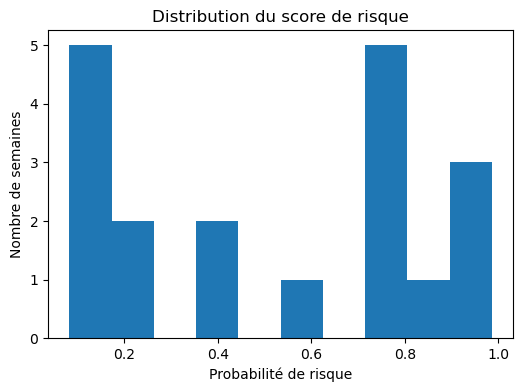

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(df_ml["risk_proba"], bins=10)
plt.title("Distribution du score de risque")
plt.xlabel("Probabilité de risque")
plt.ylabel("Nombre de semaines")
plt.show()


Voici la distribution des probabilités de risque (risk_proba) sur l’ensemble des semaines.
- Axe X : probabilité de risque (0 → 1)
- Axe Y : nombre de semaines qui tombent dans chaque tranche

On observe clairement :
- un groupe de semaines à faible risque : probas autour de 0.1 – 0.25
- quelques semaines intermédiaires : probas autour de 0.3 – 0.6
- un groupe de semaines à risque élevé : probas 0.7 – 1.0

Le score dépend des règles utilisées pour définir le risque, et doit être interprété comme un indicateur d’alerte plutôt que comme une prédiction absolue.

In [ ]:
df_ml_view = df_ml[
    [
        "week_start",
        "cluster_week",
        "distance_km",
        "sessions",
        "weekly_load",
        "high_intensity_pct",
        "risk",
        "risk_proba",
    ]
].sort_values("week_start")

df_ml_view


,week_start,cluster_week,distance_km,sessions,weekly_load,high_intensity_pct,risk,risk_proba
0,2025-09-08,0.0,31.725308,4,274.815049,0.352421,1,0.776892
1,2025-09-15,0.0,24.854587,2,229.064674,0.446168,1,0.779267
2,2025-09-22,2.0,35.172801,3,276.385871,0.205021,0,0.440466
3,2025-09-29,2.0,23.939647,3,167.165525,0.127984,0,0.091428
4,2025-10-06,0.0,38.074161,3,302.945144,0.300154,1,0.732363
5,2025-10-13,0.0,36.358290,3,288.995512,0.327073,1,0.749054
6,2025-10-20,2.0,27.883324,3,195.400587,0.185071,0,0.200546
7,2025-10-27,0.0,31.329185,3,260.538127,0.378147,1,0.768547
8,2025-11-03,0.0,32.634880,3,308.131840,0.643850,1,0.986193
9,2025-11-10,2.0,24.142424,3,177.613675,0.168220,0,0.141803


### Analyses de certaines semaines :

2025-11-03 :
- Les trois signaux sont rouges => weekly_load = 308  (> seuil)
- Le score est logiquement quasi maximal


2026-01-05 :
- Charge énorme + intensité élevée : weekly_load = 335, cluster_week = 1, high_intensity_pct = 0.64 (!!), cluster_week = 1
- Score élevé même sans ambiguïté


# TEST de recommandation avec le risque

Maintenant, ajoutons cet indicateur de risk dans notre modele de recommandation (celui niveau 2)

In [ ]:
import joblib

# -------------------------------
# LOAD SAVED MODELS
# -------------------------------
kmeans_sessions = joblib.load("models/kmeans3_session.joblib")
scaler_sessions = joblib.load("models/scaler_session.joblib")

kmeans_weeks = joblib.load("models/kmeans3_week.joblib")
scaler_weeks = joblib.load("models/scaler_week.joblib")

risk_pipeline = joblib.load("recommendation/models/risk_pipeline.joblib")


# Étape 1 — Compter les séances par semaine
week_session_counts = (
    sessions_filt.groupby(["week_start", "cluster_session"])
    .size()
    .reset_index(name="n_sessions")
)

# Étape 2 — Ajouter le cluster_week correspondant
df_week_sorted = (
    week[week["cluster_week"].notna()]  # uniquement semaines complètes
    .sort_values("week_start")
    .copy()
)

week_session_counts = week_session_counts.merge(
    df_week_sorted[["week_start", "cluster_week"]], on="week_start", how="left"
)

# Étape 3 — Calculer la distribution moyenne par cluster_week
cluster_session_distribution = (
    week_session_counts.groupby(["cluster_week", "cluster_session"])["n_sessions"]
    .mean()
    .reset_index()
)

# Étape 4 — Normaliser pour obtenir des pourcentages
cluster_session_distribution["pct"] = cluster_session_distribution.groupby(
    "cluster_week"
)["n_sessions"].transform(lambda x: x / x.sum())

# print(cluster_session_distribution)

# ------------------------------------------------------------
# 5. RISK SCORE (ML)
# ------------------------------------------------------------
FEATURES_WEEK = [
    "distance_km",
    "sessions",
    "duration_min",
    "weekly_load",
    "high_intensity_pct",
]
FEATURES_SESSION = [
    "distance_km",
    "duration_min",
    "pace_min_per_km",
    "low_intensity_pct",
    "high_intensity_pct",
]

df_ml = df_week_sorted.dropna(subset=FEATURES_WEEK).copy()
load_threshold = df_ml["weekly_load"].quantile(0.80)


def is_risky_week(row):
    if row["cluster_week"] == 0:
        return 1
    if row["weekly_load"] > load_threshold:
        return 1
    if row["high_intensity_pct"] > 0.45:
        return 1
    return 0


df_ml["risk"] = df_ml.apply(is_risky_week, axis=1)

X = df_ml[FEATURES_WEEK]
y = df_ml["risk"]

df_ml["risk_proba"] = risk_pipeline.predict_proba(df_ml[FEATURES_WEEK])[:, 1]
# ------------------------------------------------------------
# 6. RECOMMENDATION LOGIC — LEVEL 2 + RISK
# ------------------------------------------------------------
SESSION_LABELS = {
    0: "intensity",
    1: "easy",
    2: "endurance",
}


def build_week_template(cluster_week, avg_sessions, dist_df):
    rows = dist_df[dist_df["cluster_week"] == cluster_week]
    plan = []

    for _, row in rows.iterrows():
        n = round(row["pct"] * avg_sessions)
        plan += [SESSION_LABELS[row["cluster_session"]]] * n

    while len(plan) < avg_sessions:
        plan.append("easy")
    while len(plan) > avg_sessions:
        plan.pop()

    return plan

def adjust_by_risk(plan, avg_risk):
    plan = plan.copy()
    if avg_risk > 0.75:
        plan = ["easy" if s == "intensity" else s for s in plan]
    elif avg_risk < 0.30 and "intensity" not in plan:
        plan[-1] = "intensity"
    return plan


# ------------------------------------------------------------
# 7. ADJUSTMENT WITH CURRENT WEEK SESSIONS
# ------------------------------------------------------------
def adjust_with_done_sessions(plan, done_types, remaining):
    plan = plan.copy()
    for d in done_types:
        if d in plan:
            plan.remove(d)

    plan = plan[:remaining]
    while len(plan) < remaining:
        plan.append("easy")

    return plan

# ------------------------------------------------------------
# 8. FINAL PIPELINE
# ------------------------------------------------------------
today = pd.Timestamp.today().normalize()
current_week_start = today - pd.to_timedelta(today.weekday(), unit="D")

completed_weeks = df_week_sorted[df_week_sorted["week_start"] < current_week_start]
last_3w = completed_weeks.tail(3)

dominant_cluster = int(last_3w["cluster_week"].mode()[0])
avg_sessions = int(np.clip(round(last_3w["sessions"].mean()), 2, 5))

avg_risk = df_ml[df_ml["week_start"].isin(last_3w["week_start"])]["risk_proba"].mean()

base_plan = build_week_template(
    dominant_cluster,
    avg_sessions,
    cluster_session_distribution,
)

risk_adjusted_plan = adjust_by_risk(base_plan, avg_risk)

current_sessions = sessions_filt[sessions_filt["week_start"] == current_week_start]

done_types = current_sessions["cluster_session"].map(SESSION_LABELS).tolist()

remaining_sessions = max(0, avg_sessions - len(done_types))

final_plan = adjust_with_done_sessions(
    risk_adjusted_plan,
    done_types,
    remaining_sessions,
)
# ------------------------------------------------------------
# 9. OUTPUT (FOR LLM / API)
# ------------------------------------------------------------
recommendation_output = {
    "target_sessions": avg_sessions,
    "dominant_week_cluster": int(dominant_cluster),
    "avg_risk_last_3w": round(avg_risk, 2),
    "risk_level": (
        "high" if avg_risk > 0.75 else "moderate" if avg_risk > 0.4 else "low"
    ),
    "base_plan": base_plan,
    "adjusted_plan_remaining": final_plan,
    "done_sessions": done_types,
}
print("Recommandation:")
print(recommendation_output)


Recommandation:
{'target_sessions': 3, 'dominant_week_cluster': 0, 'avg_risk_last_3w': 0.92, 'risk_level': 'high', 'base_plan': ['intensity', 'easy', 'endurance'], 'adjusted_plan_remaining': ['easy', 'easy', 'endurance'], 'done_sessions': []}


1. target_sessions: 3

- Objectif hebdomadaire recommandé : 3 séances
- Comment on l’obtient : moyenne du nombre de séances sur les 3 dernières semaines complètes
- bornée entre 2 et 5 pour rester réaliste
- Interprétation : “Tu t’entraînes généralement autour de 3 séances par semaine, on conserve ce rythme.”

2. dominant_week_cluster: 1

- Profil dominant récent = cluster 1
- Rappel : Cluster 1 = semaine intensive / charge élevée
- Comment : mode() des cluster_week sur les 3 dernières semaines complètes
- Coach : “Sur les dernières semaines, ton entraînement est majoritairement intensif.”
- Important : ce n’est pas un jugement, c’est un diagnostic de dynamique

3. avg_risk_last_3w: 0.61

- Score de risque moyen sur les 3 dernières semaines
- calculé via le modèle ML (régression logistique)
- valeur ∈ [0,1]
- 0.64 = zone intermédiaire haute
- Coach : “Tu n’es pas en surcharge critique, mais la charge commence à être significative.”

4. risk_level: 'moderate'

- Catégorisation lisible du score
- Règles :
    - < 0.4 → faible
    - 0.4 – 0.75 → modéré
    - > 0.75 → élevé
- Donc ici : 0.64 → modéré
- Coach : “On continue à progresser, mais avec vigilance.”

5. base_plan: ['intensity', 'easy', 'endurance']

- Plan “théorique” de la semaine
- Comment il est construit :
    - basé sur la structure moyenne des semaines du cluster 1
    - projetée sur 3 séances
    - issu de cluster_session_distribution
- Autrement dit : “Quand tu es dans une dynamique intensive, tes semaines ressemblent statistiquement à ça.”
- Ce plan n’est pas encore personnalisé au contexte actuel.

6. done_sessions: ['intensity']

- Ce que tu as déjà fait cette semaine
- extrait des séances réelles de la semaine en cours
- cluster de séance = intensity
- Coach : “Tu as déjà placé ta séance la plus exigeante.”
- C’est une info clé pour la suite.

7. adjusted_plan_remaining: ['easy', 'endurance']

- LE RÉSULTAT FINAL UTILE : C’est ce que le système recommande pour le reste de la semaine.

# Ajustement de la recommandation : Lorsque la semaine en cours est terminé
Lorsque le nombre de seance moyen est atteint dans la semaine, on considere la semaine comme terminé. Le système de recommandation agit donc pour la semaine suivante.

In [ ]:
import joblib

# -------------------------------
# LOAD SAVED MODELS
# -------------------------------
kmeans_sessions = joblib.load("models/kmeans3_session.joblib")
scaler_sessions = joblib.load("models/scaler_session.joblib")

kmeans_weeks = joblib.load("models/kmeans3_week.joblib")
scaler_weeks = joblib.load("models/scaler_week.joblib")

risk_pipeline = joblib.load("recommendation/models/risk_pipeline.joblib")


# Étape 1 — Compter les séances par semaine
week_session_counts = (
    sessions_filt.groupby(["week_start", "cluster_session"])
    .size()
    .reset_index(name="n_sessions")
)

# Étape 2 — Ajouter le cluster_week correspondant
week_session_counts = week_session_counts.merge(
    df_week_sorted[["week_start", "cluster_week"]], on="week_start", how="left"
)

# Étape 3 — Calculer la distribution moyenne par cluster_week
cluster_session_distribution = (
    week_session_counts.groupby(["cluster_week", "cluster_session"])["n_sessions"]
    .mean()
    .reset_index()
)

# Étape 4 — Normaliser pour obtenir des pourcentages
cluster_session_distribution["pct"] = cluster_session_distribution.groupby(
    "cluster_week"
)["n_sessions"].transform(lambda x: x / x.sum())

# print(cluster_session_distribution)

# ------------------------------------------------------------
# 5. RISK SCORE (ML)
# ------------------------------------------------------------
FEATURES_WEEK = [
    "distance_km",
    "sessions",
    "duration_min",
    "weekly_load",
    "high_intensity_pct",
]
FEATURES_SESSION = [
    "distance_km",
    "duration_min",
    "pace_min_per_km",
    "low_intensity_pct",
    "high_intensity_pct",
]

df_ml = df_week_sorted.dropna(subset=FEATURES_WEEK).copy()
load_threshold = df_ml["weekly_load"].quantile(0.80)


def is_risky_week(row):
    if row["cluster_week"] == 1:
        return 1
    if row["weekly_load"] > load_threshold:
        return 1
    if row["high_intensity_pct"] > 0.45:
        return 1
    return 0


df_ml["risk"] = df_ml.apply(is_risky_week, axis=1)

X = df_ml[FEATURES_WEEK]
y = df_ml["risk"]


df_ml = df_week_sorted.dropna(subset=FEATURES_WEEK).copy()

df_ml["risk_proba"] = risk_pipeline.predict_proba(df_ml[FEATURES_WEEK])[:, 1]
# ------------------------------------------------------------
# 6. RECOMMENDATION LOGIC — LEVEL 2 + RISK
# ------------------------------------------------------------
SESSION_LABELS = {
    0: "intensity",
    1: "easy",
    2: "endurance",
}


def build_week_template(cluster_week, avg_sessions, dist_df):
    rows = dist_df[dist_df["cluster_week"] == cluster_week]
    plan = []

    for _, row in rows.iterrows():
        n = round(row["pct"] * avg_sessions)
        plan += [SESSION_LABELS[row["cluster_session"]]] * n

    while len(plan) < avg_sessions:
        plan.append("easy")
    while len(plan) > avg_sessions:
        plan.pop()

    return plan


def adjust_by_risk(plan, avg_risk):
    plan = plan.copy()
    if avg_risk > 0.75:
        plan = ["easy" if s == "intensity" else s for s in plan]
    elif avg_risk < 0.30 and "intensity" not in plan:
        plan[-1] = "intensity"
    return plan


# ------------------------------------------------------------
# 7. ADJUSTMENT WITH CURRENT WEEK SESSIONS
# ------------------------------------------------------------
def adjust_with_done_sessions(plan, done_types, remaining):
    plan = plan.copy()
    for d in done_types:
        if d in plan:
            plan.remove(d)

    plan = plan[:remaining]
    while len(plan) < remaining:
        plan.append("easy")

    return plan


# ------------------------------------------------------------
# 8. FINAL PIPELINE
# ------------------------------------------------------------
current_week_start = df_week_sorted["week_start"].max()

completed_weeks = df_week_sorted[df_week_sorted["week_start"] < current_week_start]
last_3w = completed_weeks.tail(3)

dominant_cluster = int(last_3w["cluster_week"].mode()[0])
avg_sessions = int(np.clip(round(last_3w["sessions"].mean()), 2, 5))

avg_risk = df_ml[df_ml["week_start"].isin(last_3w["week_start"])]["risk_proba"].mean()

base_plan = build_week_template(
    dominant_cluster,
    avg_sessions,
    cluster_session_distribution,
)

risk_adjusted_plan = adjust_by_risk(base_plan, avg_risk)

current_sessions = sessions_filt[sessions_filt["week_start"] == current_week_start]

done_types = current_sessions["cluster_session"].map(SESSION_LABELS).tolist()

remaining_sessions = max(0, avg_sessions - len(done_types))

final_plan = adjust_with_done_sessions(
    risk_adjusted_plan,
    done_types,
    remaining_sessions,
)

week_complete = len(final_plan) == 0
print("✅ Week complete:", week_complete)

if week_complete:
    print("\n🔄 SEMAINE COMPLÈTE → PLANIFICATION SEMAINE SUIVANTE")

    completed_weeks = df_week_sorted[df_week_sorted["week_start"] <= current_week_start]

    last_3w = completed_weeks.tail(3)

    dominant_cluster = int(last_3w["cluster_week"].mode()[0])
    avg_sessions = int(np.clip(round(last_3w["sessions"].mean()), 2, 5))

    avg_risk = df_ml[df_ml["week_start"].isin(last_3w["week_start"])][
        "risk_proba"
    ].mean()

    print("\n📈 Weekly stats used for NEXT WEEK risk computation:")
    print(last_3w[["week_start"] + FEATURES_WEEK].to_string(index=False))
    print("📈 Avg risk proba (next week):", round(avg_risk, 3))

    base_plan = build_week_template(
        dominant_cluster,
        avg_sessions,
        cluster_session_distribution,
    )

    risk_adjusted_plan = adjust_by_risk(base_plan, avg_risk)

    final_plan = risk_adjusted_plan

# ------------------------------------------------------------
# 9. OUTPUT (FOR LLM / API)
# ------------------------------------------------------------
recommendation_output = {
    "target_sessions": avg_sessions,
    "dominant_week_cluster": int(dominant_cluster),
    "avg_risk_last_3w": round(avg_risk, 3),
    "risk_level": (
        "high" if avg_risk > 0.75 else "moderate" if avg_risk > 0.4 else "low"
    ),
    "base_plan": base_plan,
    "adjusted_plan_remaining": final_plan,
    "done_sessions": [] if week_complete else done_types,
    "week_complete": week_complete,
}

print("Recommandation:")
print(recommendation_output)


✅ Week complete: True

🔄 SEMAINE COMPLÈTE → PLANIFICATION SEMAINE SUIVANTE

📈 Weekly stats used for NEXT WEEK risk computation:
week_start  distance_km  sessions  duration_min  weekly_load  high_intensity_pct
2025-12-29    30.239698         3    186.267078   268.243614            0.440102
2026-01-05    35.281388         4    230.093800   335.621439            0.458629
2026-01-12    35.502520         3    219.547000   328.151493            0.494675
📈 Avg risk proba (next week): 0.924
Recommandation:
{'target_sessions': 3, 'dominant_week_cluster': 0, 'avg_risk_last_3w': 0.924, 'risk_level': 'high', 'base_plan': ['intensity', 'easy', 'endurance'], 'adjusted_plan_remaining': ['easy', 'easy', 'endurance'], 'done_sessions': [], 'week_complete': True}


# Moteur de recommandation d’entraînement – Running Coach

## Objectif du modèle

L’objectif du modèle est de recommander les **types de séances à réaliser**, soit pour le reste de la semaine en cours, soit pour la **semaine suivante lorsque la semaine est déjà complétée**, en tenant compte :

* de l’historique récent d’entraînement,
* de la structure habituelle des semaines similaires,
* du niveau de risque de surcharge à court terme,
* et des séances déjà effectuées dans la semaine courante.

Le système **ne cherche pas à prédire une performance ou une blessure**, mais à **guider l’entraînement de manière cohérente et prudente**, comme le ferait un coach humain expérimenté.

---

## Vue d’ensemble de l’architecture

Le modèle repose sur **trois briques complémentaires**, combinées dans un pipeline explicable :

1. **Clustering des séances** → caractériser les types d’entraînement (niveau micro)
2. **Clustering des semaines** → caractériser les profils de charge hebdomadaire (niveau macro)
3. **Score de risque (Machine Learning)** → moduler la recommandation pour éviter surcharge ou stagnation

Ces briques sont ensuite orchestrées par un moteur de recommandation déterministe.

---

## 1. Clustering des séances (niveau micro)

### Objectif

Identifier automatiquement les **types de séances réellement effectuées** par l’utilisateur, sans règles manuelles.

### Données utilisées

Pour chaque séance :

* distance (km)
* durée (min)
* allure (min/km)
* % basse intensité
* % haute intensité

### Méthode

* Standardisation des variables
* KMeans avec 3 clusters

### Résultat

Chaque séance est assignée à un `cluster_session`, interprété comme :

| cluster_session | Type de séance         |
| --------------- | ---------------------- |
| 0               | Séance intensive       |
| 1               | Séance facile / courte |
| 2               | Séance endurance       |

Ce clustering permet de qualifier automatiquement les séances **à partir des données**, sans heuristique arbitraire.

---

## 2. Clustering des semaines (niveau macro)

### Objectif

Identifier les **profils de semaines d’entraînement**, en termes de volume, intensité et structure.

### Données utilisées

Pour chaque semaine :

* distance totale
* nombre de séances
* durée totale
* charge hebdomadaire
* % haute intensité

### Méthode

* Standardisation
* KMeans avec 3 clusters

### Résultat

Chaque semaine reçoit un `cluster_week`, interprété comme :

| cluster_week | Interprétation                                                      |
| ------------ | ------------------------------------------------------------------- |
| 0            | Semaine maîtrisée / orientée endurance                              |
| 1            | Semaine intensive / charge élevée                                   |
| 2            | Semaine courte ou déséquilibrée (reprise, contrainte, interruption) |

Le clustering joue ici un **rôle de diagnostic global** de la dynamique d’entraînement.

---

## 3. Apprentissage de la structure des semaines

### Objectif

Comprendre **comment les semaines sont composées**, en termes de types de séances.

### Principe

Pour chaque `cluster_week`, on calcule la distribution moyenne des types de séances observés :

P(cluster_session | cluster_week)

### Exemple (simplifié)

* Semaine intensive → ~35% intensité, ~30% endurance, ~35% easy
* Semaine maîtrisée → majorité de easy + endurance
* Semaine courte → peu de séances, souvent faciles

Ces distributions servent de **templates hebdomadaires data-driven**.

---

## 4. Génération du plan hebdomadaire théorique

### Étapes

1. Sélection des **3 dernières semaines complètes**
2. Identification du `cluster_week` dominant
3. Calcul du nombre moyen de séances
4. Projection de la distribution du cluster sur ce nombre

### Exemple

Si :

* cluster dominant = semaine intensive
* nombre moyen de séances = 3

Alors :

```
Plan théorique = [intensity, easy, endurance]
```

Ce plan représente la **structure habituelle observée**, avant toute adaptation contextuelle.

---

## 5. Score de risque (Machine Learning)

### Objectif

Évaluer le **niveau de risque de surcharge à court terme**, à l’échelle hebdomadaire.

### Construction de la cible (règles métier)

Une semaine est considérée “à risque” si **au moins une** des conditions suivantes est vraie :

* elle appartient au cluster intensif, OU
* sa charge est dans les 20% les plus élevées, OU
* la part de haute intensité est très élevée (>45%)

Cela définit une variable binaire `risk`.

### Modèle ML

* Régression logistique
* Variables d’entrée :

  * distance
  * nombre de séances
  * durée
  * charge
  * % haute intensité

### Sortie

Le modèle produit un score probabiliste :

```
risk_proba ∈ [0, 1]
```

Ce score n’est **ni médical ni prédictif**, mais un **indicateur gradué de vigilance**.

---

## 6. Modulation de la recommandation par le risque

Le score de risque agit comme un **modulateur**, jamais comme un décideur unique.

### Règles principales

* **Risque élevé** → réduction ou suppression des séances intensives
* **Risque modéré** → maintien du plan théorique
* **Risque faible** → possibilité d’introduire une séance intense si absente

Le système **corrige les habitudes**, au lieu de les reproduire mécaniquement.

---

## 7. Ajustement à la semaine en cours (temps réel)

### Problème traité

La semaine peut être **déjà entamée** (ex. mardi, jeudi, samedi).

### Solution

1. Identification des séances déjà effectuées
2. Suppression de ces types du plan théorique
3. Recommandation uniquement des séances restantes

### Exemple

```
Plan théorique : [intensity, easy, endurance]
Séance déjà faite : intensity
Recommandation finale : [easy, endurance]
```

La recommandation devient **contextuelle, immédiate et actionnable**.

---

## 8. Gestion explicite des semaines complètes

### Cas particulier

Si **toutes les séances prévues** ont déjà été réalisées :

* la semaine est considérée comme **complète**
* le moteur bascule automatiquement en **mode “semaine suivante”**

### Conséquences

* la semaine complétée est **incluse** dans l’analyse des 3 dernières semaines
* le risque est **recalculé** en intégrant cette semaine
* un **nouveau plan hebdomadaire complet** est généré
* aucune séance n’est considérée comme “déjà faite”

Le système se comporte comme un coach qui **tire des enseignements de la semaine écoulée avant de planifier la suivante**.

---

## 9. Sortie finale du moteur

Exemple de sortie lorsque la semaine est en cours :

```json
{
  "target_sessions": 3,
  "dominant_week_cluster": 1,
  "avg_risk_last_3w": 0.61,
  "risk_level": "moderate",
  "base_plan": ["intensity", "easy", "endurance"],
  "adjusted_plan_remaining": ["easy", "endurance"],
  "done_sessions": ["intensity"],
  "week_complete": false
}
```

Exemple de sortie lorsque la semaine est terminée :

```json
{
  "target_sessions": 3,
  "dominant_week_cluster": 1,
  "avg_risk_last_3w": 0.91,
  "risk_level": "high",
  "base_plan": ["easy", "easy", "endurance"],
  "adjusted_plan_remaining": ["easy", "easy", "endurance"],
  "done_sessions": [],
  "week_complete": true
}
```

---

## Conclusion

Ce moteur de recommandation :

* combine clustering non supervisé, règles métier et ML léger,
* est entièrement explicable et auditable,
* s’adapte au **temps réel** et au **rythme de l’athlète**,
* évite les décisions arbitraires,
* agit comme un **coach adaptatif**, pas comme un simple moteur statistique.

Il est particulièrement adapté à des contextes de données personnelles limitées, comme c’est souvent le cas dans le sport amateur, tout en restant robuste, cohérent et évolutif.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

weeks = pd.read_csv("weeks_received.csv")

weeks["week_start"] = pd.to_datetime(weeks["week_start"])
weeks["week_end"] = pd.to_datetime(weeks["week_end"])

# Correction du nombre de sessions (déjà fait)
weeks.loc[
    (weeks["week_start"] == "2025-09-08") & (weeks["week_end"] == "2025-09-15"),
    "sessions",
] = 4
weeks = weeks[weeks["week_start"] >= "2025-09-08"].copy()

sessions = pd.read_csv("sessions_received.csv")
sessions["date"] = pd.to_datetime(sessions["date"])
# je fais tous ça car il y a des données découpés pour la meme journée
sessions = sessions.groupby("date", as_index=False).agg(
    {
        "distance_km": "sum",
        "duration_min": "sum",
        "z1_min": "sum",
        "z2_min": "sum",
        "z3_min": "sum",
        "z4_min": "sum",
        "z5_min": "sum",
    }
)
# pace global (min / km)
sessions["pace_min_per_km"] = sessions["duration_min"] / sessions["distance_km"]

# intensité (Z3 = basse intensité)
sessions["low_intensity_pct"] = (
    sessions["z1_min"] + sessions["z2_min"] + sessions["z3_min"]
) / sessions["duration_min"]

sessions["high_intensity_pct"] = (sessions["z4_min"] + sessions["z5_min"]) / sessions[
    "duration_min"
]
sessions = sessions[sessions["date"] >= "2025-09-14"].copy()


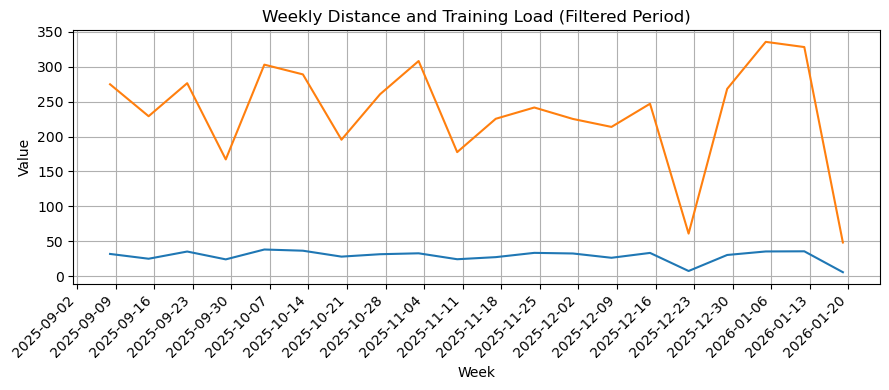

In [ ]:
# --------------------
# GRAPH 1: Weekly distance & load
# --------------------
plt.figure(figsize=(9, 4))

plt.plot(weeks["week_start"], weeks["distance_km"])
plt.plot(weeks["week_start"], weeks["weekly_load"])

plt.title("Weekly Distance and Training Load (Filtered Period)")
plt.xlabel("Week")
plt.ylabel("Value")

plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # 1 tick par semaine
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


La distance hebdomadaire est relativement stable (≈ 25–38 km). => axe bleu

La charge d’entraînement varie beaucoup plus fortement : pics >300, creux très marqués (≈60 puis ≈50).

Certaines semaines ont : un volume comparable, mais une charge très différente → effet direct de l’intensité.

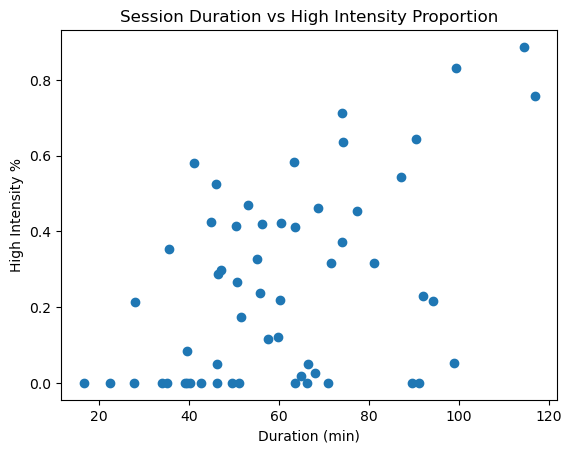

In [ ]:
# --------------------
# GRAPH 2: Session duration vs intensity
# --------------------
plt.figure()
plt.scatter(sessions["duration_min"], sessions["high_intensity_pct"])
plt.title("Session Duration vs High Intensity Proportion")
plt.xlabel("Duration (min)")
plt.ylabel("High Intensity %")
plt.show()


Forte dispersion :
- séances de 40–60 min allant de 0% à >60% d’intensité,
- séances longues parfois très intenses (>80%).
- Beaucoup de séances très faciles (0–5%),
- Quelques séances qualitativement très agressives.
- L’intensité n’est pas corrélée linéairement à la durée.

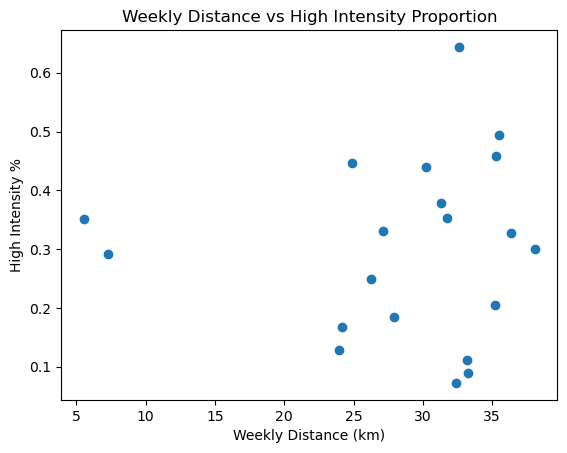

In [ ]:
# --------------------
# GRAPH 3: Weekly distance vs intensity
# --------------------
plt.figure()
plt.scatter(weeks["distance_km"], weeks["high_intensity_pct"])
plt.title("Weekly Distance vs High Intensity Proportion")
plt.xlabel("Weekly Distance (km)")
plt.ylabel("High Intensity %")
plt.show()


Pour des distances similaires (≈30–35 km), la proportion d’intensité varie fortement (≈10% à >60%). On observe plusieurs profils de semaines :
- volume modéré + endurance,
- volume modéré + forte intensité,
- faible volume + intensité élevée.

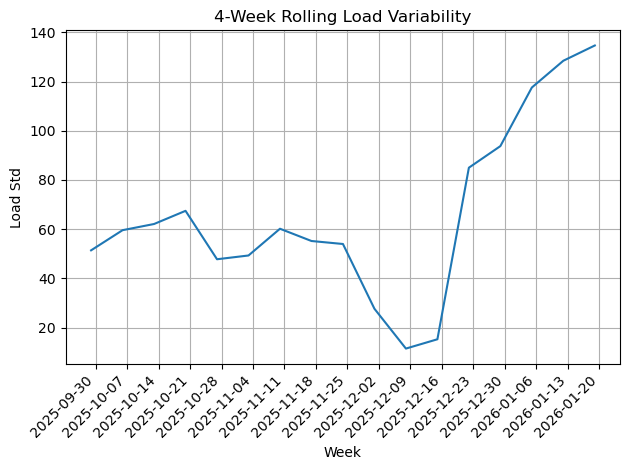

In [ ]:
# --------------------
# GRAPH 4: Weekly load variability (rolling std)
# --------------------
weeks_sorted = weeks.sort_values("week_start").copy()
weeks_sorted["rolling_load_std_4w"] = weeks_sorted["weekly_load"].rolling(4).std()

plt.figure()
plt.plot(weeks_sorted["week_start"], weeks_sorted["rolling_load_std_4w"])

plt.title("4-Week Rolling Load Variability")
plt.xlabel("Week")
plt.ylabel("Load Std")

plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # 1 tick par semaine
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


Une augmentation rapide de la variabilité de charge suggère une diminution de la capacité d’absorption de la charge et une accumulation de fatigue.

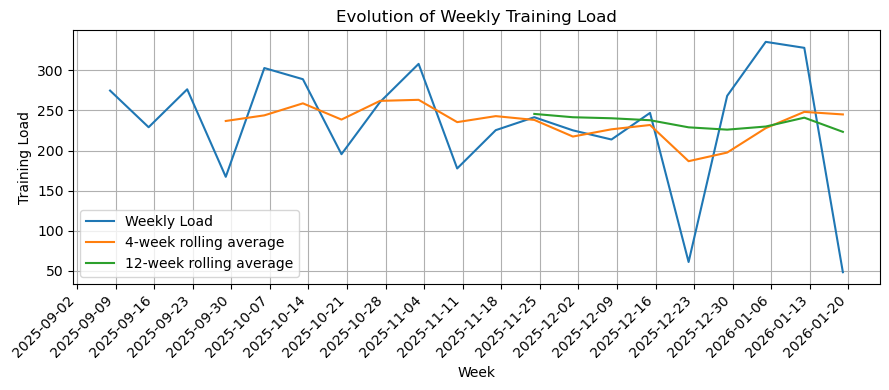

In [ ]:
# ---- GRAPH: Weekly load evolution ----
weeks["load_4w_avg"] = weeks["weekly_load"].rolling(4).mean()
weeks["load_12w_avg"] = weeks["weekly_load"].rolling(12).mean()

plt.figure(figsize=(9, 4))

plt.plot(weeks["week_start"], weeks["weekly_load"], label="Weekly Load")
plt.plot(weeks["week_start"], weeks["load_4w_avg"], label="4-week rolling average")
plt.plot(weeks["week_start"], weeks["load_12w_avg"], label="12-week rolling average")

plt.title("Evolution of Weekly Training Load")
plt.xlabel("Week")
plt.ylabel("Training Load")
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # 1 tick par semaine
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")


plt.legend()
plt.tight_layout()
plt.show()


- La charge hebdomadaire brute (ligne bleue) est : très fluctuante, avec des pics, des creux, et des ruptures nettes.
- La moyenne mobile 4 semaines (orange) : capte la fatigue récente / charge aiguë, réagit rapidement aux changements.
- La moyenne mobile 12 semaines (verte) : représente la charge chronique / habituelle, évolue lentement.

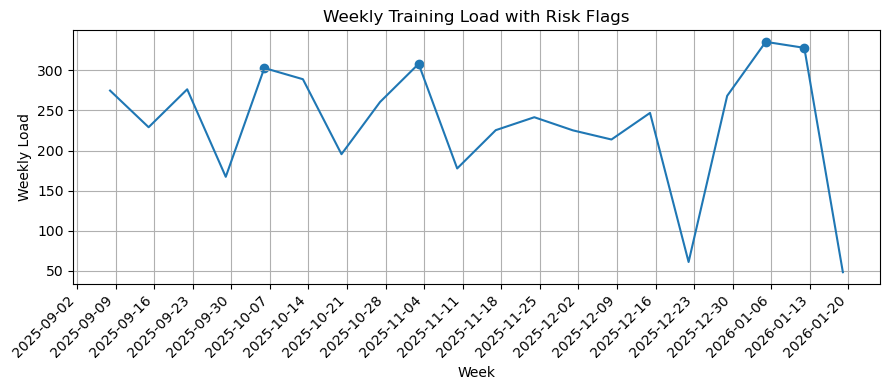

In [ ]:
# --------------------
# Compute risk flag (business rules)
# --------------------
workload_threshold = weeks["weekly_load"].quantile(0.8)

weeks["risk_flag"] = (weeks["weekly_load"] >= workload_threshold) | (
    weeks["high_intensity_pct"] > 0.45
)

# --------------------
# Compute ACWR
# --------------------
weeks["acute_load"] = weeks["weekly_load"].rolling(4).mean()
weeks["chronic_load"] = weeks["weekly_load"].rolling(12).mean()
weeks["acwr"] = weeks["acute_load"] / weeks["chronic_load"]

# --------------------
# Compute rolling variability
# --------------------
weeks["rolling_std_4w"] = weeks["weekly_load"].rolling(4).std()

# ======================================================
# 🟦 A️⃣ Weekly Load + Risk Flag
# ======================================================
plt.figure(figsize=(9, 4))
plt.plot(weeks["week_start"], weeks["weekly_load"])
plt.scatter(
    weeks.loc[weeks["risk_flag"], "week_start"],
    weeks.loc[weeks["risk_flag"], "weekly_load"],
)
plt.grid(True)
plt.title("Weekly Training Load with Risk Flags")
plt.xlabel("Week")
plt.ylabel("Weekly Load")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # 1 tick par semaine
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


La courbe de weekly_load montre :
- une alternance de semaines modérées (≈200–250),
- des pics élevés (>300),
- et des ruptures nettes (semaine très basse autour de 60–50).

Les points (risk) apparaissent sur certains pics élevés, mais pas systématiquement sur toutes les semaines chargées.

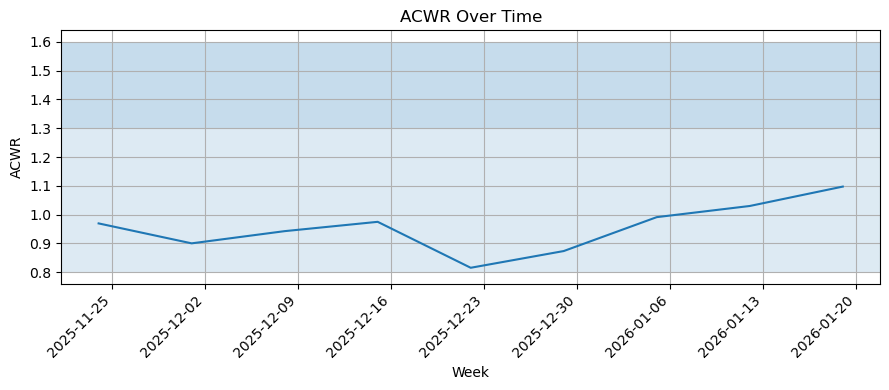

In [ ]:
# ======================================================
# 🟦 B️⃣ ACWR over time with zones
# ======================================================
plt.figure(figsize=(9, 4))
plt.plot(weeks["week_start"], weeks["acwr"])

plt.axhspan(0.8, 1.3, alpha=0.15)
plt.axhspan(1.3, 1.6, alpha=0.25)

plt.title("ACWR Over Time")
plt.xlabel("Week")
plt.ylabel("ACWR")

plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # 1 tick par semaine
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


L’ACWR oscille principalement autour de ~0.9–1.1 :
- zone de stabilité,
- charge aiguë cohérente avec la charge chronique.

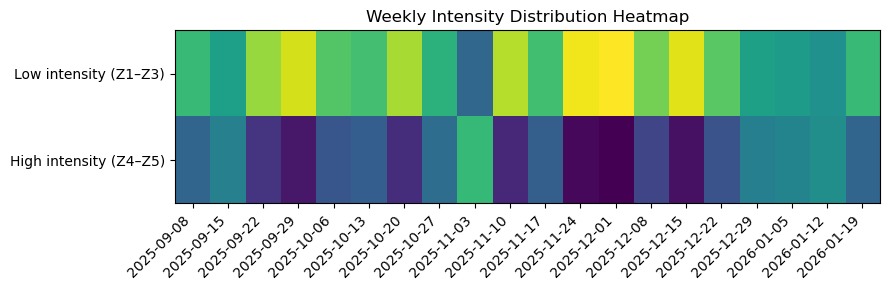

In [ ]:
# ======================================================
# 🟦 C️⃣ Heatmap Week × Intensity (Low vs High)
# ======================================================
intensity_matrix = np.vstack(
    [
        weeks["low_intensity_pct"].values,
        weeks["high_intensity_pct"].values,
    ]
)

plt.figure(figsize=(9, 3))
plt.imshow(intensity_matrix, aspect="auto")

plt.yticks([0, 1], ["Low intensity (Z1–Z3)", "High intensity (Z4–Z5)"])
plt.xticks(
    ticks=np.arange(len(weeks)),
    labels=weeks["week_start"].dt.strftime("%Y-%m-%d"),
    rotation=45,
    ha="right",
)

plt.title("Weekly Intensity Distribution Heatmap")
plt.tight_layout()
plt.show()



- Chaque colonne = une semaine,
- Chaque ligne = type d’intensité.

Les couleurs montrent :
- des semaines dominées par l’endurance,
- des semaines avec une forte proportion d’intensité,
- une alternance claire.